In [1]:
#import requests
#import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
import warnings 
warnings.filterwarnings('ignore')
from sklearn.neighbors import KNeighborsRegressor

In [57]:
import scipy.stats
from sklearn.preprocessing import StandardScaler,RobustScaler
from sklearn.cluster import KMeans
from sklearn.metrics import precision_score ,f1_score ,roc_auc_score, accuracy_score
from sklearn.decomposition import PCA

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
def Convert_Time(row): 
    tokens = row.split(':')
    if len(tokens) ==2:
        return int(tokens[0]) + int(tokens[1])/60

In [6]:
def Rest_days(row):
    if isinstance(row,int) or isinstance(row,float):
        return row
    tokens = row.split(' ')
    return int(tokens[0])

In [8]:
def get_matches_played_in_szn(df):
    df = df.copy()
    gp_arr=[]
    for year,yr_df in df.groupby('Season'):
        for team,team_df in yr_df.groupby('Team'):
            team_df['Matches_Played'] = 1
            gd_cum = team_df['Matches_Played'].cumsum()
            gp_arr.append(gd_cum)
    cum = pd.concat(gp_arr)
    cum = cum.sort_index()
    #cum.columns = cum_cols
    df_with_cum = pd.concat([df,cum],axis=1)
    return df_with_cum

In [9]:
def get_cum_by_col(df,grouper,grouper_name,cols,agg_func):
    df = df.copy()
    gp_arr=[]
    for team,team_df in df.groupby('Team'):
        for g,gd in team_df.groupby([grouper])[cols]:
            #print(g)
            #display(gd)
            if agg_func == 'sum':
                gd_cum = gd.shift(1).cumsum()
            if agg_func == 'mean':
                gd_cum = gd.shift(1).expanding().mean()
            for col in cols:
                gd_cum[col].fillna(gd_cum[col].mean(), inplace=True)
            gp_arr.append(gd_cum)
    cum = pd.concat(gp_arr)
    cum = cum.sort_index()
    alias = '_this_'+grouper_name+'_'+agg_func
    cum_cols = [col+alias for col in cols]
    cum.columns = cum_cols
    df_with_cum = pd.concat([df,cum],axis=1)
    return df_with_cum 

In [182]:
def rolling_average_or_sum(df,cols,window,agg_func):
    df = df.copy()
    alias = '_last_'+str(window)+'gm_'+agg_func
    new_cols = [col+alias for col in cols]
    gp_arr=[]
    for year,yr_df in df.groupby('Season'):
        for team,team_df in yr_df.groupby('Team'):
            #for g,gd in team_df.groupby([grouper])[cols]:
                if agg_func == 'sum':
                    rolling = team_df[cols].shift(1).rolling(window).sum()
                if agg_func == 'mean':
                    rolling = team_df[cols].shift(1).rolling(window).mean()
                    
                rolling.columns = new_cols   
                gp_arr.append(rolling)
    #display(rolling)
    rolling_df = pd.concat(gp_arr)
    rolling_df = rolling_df.sort_index()
    #rolling.columns = new_cols
    df_rolling = pd.concat([df,rolling_df],axis=1)
    return df_rolling

In [166]:
c ='Standard_Gls	Standard_Sh	Standard_SoT	Standard_SoT%	Standard_G/Sh	Standard_G/SoT	Standard_Dist	Standard_FK	Standard_PK	Standard_PKatt'.split('	')

In [167]:
c

['Standard_Gls',
 'Standard_Sh',
 'Standard_SoT',
 'Standard_SoT%',
 'Standard_G/Sh',
 'Standard_G/SoT',
 'Standard_Dist',
 'Standard_FK',
 'Standard_PK',
 'Standard_PKatt']

In [183]:
rolling_average_or_sum(df=df,cols=advance_stats_cols,window=2,agg_func='sum')

,Unnamed: 0,Date,Time,Comp,Round,Day,Venue,Result,GF,GA,Opponent,xG,xGA,Poss,Attendance,Captain,Formation,Referee,Match Report,Notes,Team,Standard_Gls,Standard_Sh,Standard_SoT,Standard_SoT%,Standard_G/Sh,Standard_G/SoT,Standard_Dist,Standard_FK,Standard_PK,Standard_PKatt,Expected_xG,Expected_npxG,Expected_npxG/Sh,Expected_G-xG,Expected_np:G-xG,SCA_Types_SCA,SCA_Types_PassLive,SCA_Types_PassDead,SCA_Types_Drib,SCA_Types_Sh,SCA_Types_Fld,SCA_Types_Def,GCA_Types_GCA,GCA_Types_PassLive,GCA_Types_PassDead,GCA_Types_Drib,GCA_Types_Sh,GCA_Types_Fld,GCA_Types_Def,Tackles_Tkl,Tackles_TklW,Tackles_Def_3rd,Tackles_Mid_3rd,Tackles_Att_3rd,Vs_Dribbles_Tkl,Vs_Dribbles_Att,Vs_Dribbles_Tkl%,Vs_Dribbles_Past,Pressures_Press,Pressures_Succ,Pressures_%,Pressures_Def_3rd,Pressures_Mid_3rd,Pressures_Att_3rd,Blocks_Blocks,Blocks_Sh,Blocks_ShSv,Blocks_Pass,Def_Int,Def_Tkl+Int,Def_Clr,Def_Err,GK_Perf_SoTA,GK_Perf_GA,GK_Perf_Saves,GK_Perf_Save%,GK_Perf_CS,GK_Perf_PSxG,GK_Perf_PSxG+/-,GK_Penalty_PKatt,GK_Penalty_PKA,GK_Penalty_PKsv,GK_Penalty_PKm,GK_Launch_Cmp,GK_Launch_Att,GK_Launch_Cmp%,GK_Passes_Att,GK_Passes_Thr,GK_Passes_Launch%,GK_Passes_AvgLen,Gk_Goal_Kk_Att,Gk_Goal_Kk_Launch%,Gk_Goal_Kk_AvgLen,GK_Crosses_Opp,GK_Crosses_Stp,GK_Crosses_Stp%,Gk_Sweeper_#OPA,Gk_Sweeper_AvgDist,Passing_Total_Cmp,Passing_Total_Att,Passing_Total_Cmp%,Passing_Total_TotDist,Passing_Total_PrgDist,Passing_Short_Cmp,Passing_Short_Att,Passing_Short_Cmp%,Passing_Medium_Cmp,Passing_Medium_Att,Passing_Medium_Cmp%,Passing_Long_Cmp,Passing_Long_Att,Passing_Long_Cmp%,Passing_Ast,Passing_xA,Passing_KP,Passing_1/3,Passing_PPA,Passing_CrsPA,Passing_Prog,Misc_Stats_CrdY,Misc_Stats_CrdR,Misc_Stats_2CrdY,Misc_Stats_Fls,Misc_Stats_Fld,Misc_Stats_Off,Misc_Stats_Crs,Misc_Stats_Int,Misc_Stats_TklW,Misc_Stats_PKwon,Misc_Stats_PKcon,Misc_Stats_OG,Misc_Stats_Recov,Misc_Stats_Aerial_DuelsWon,Misc_Stats_Aerial_DuelsLost,Misc_Stats_Aerial_DuelsWon%,Season,Month,Win,Draw,Lose,Points,Total_Points,Total_GF,Total_GA,Total_Win,Total_Draw,Total_Loss,Points_Avg_for_szn,GF_Avg_for_szn,GA_Avg_for_szn,Win_Avg_for_szn,Draw_Avg_for_szn,Loss_Avg_for_szn,Away_Win,Away_Draw,Away_Loss,Home_Win,Home_Draw,Home_Loss,Points_last_1gm_sum,Win_last_1gm_sum,Draw_last_1gm_sum,Lose_last_1gm_sum,GF_last_1gm_sum,GA_last_1gm_sum,Away_Win_last_1gm_sum,Away_Draw_last_1gm_sum,Away_Loss_last_1gm_sum,Home_Win_last_1gm_sum,Home_Draw_last_1gm_sum,Home_Loss_last_1gm_sum,Points_last_2gm_sum,Win_last_2gm_sum,Draw_last_2gm_sum,Lose_last_2gm_sum,GF_last_2gm_sum,GA_last_2gm_sum,Away_Win_last_2gm_sum,Away_Draw_last_2gm_sum,Away_Loss_last_2gm_sum,Home_Win_last_2gm_sum,Home_Draw_last_2gm_sum,Home_Loss_last_2gm_sum,Points_last_3gm_mean,Win_last_3gm_mean,Draw_last_3gm_mean,Lose_last_3gm_mean,GF_last_3gm_mean,GA_last_3gm_mean,Away_Win_last_3gm_mean,Away_Draw_last_3gm_mean,Away_Loss_last_3gm_mean,Home_Win_last_3gm_mean,Home_Draw_last_3gm_mean,Home_Loss_last_3gm_mean,Poss_last_3gm_mean,Prev_match_date,Rest,Prev_comp,Prev_Opp,Played_Opp_X_times,GF_this_month_sum,GA_this_month_sum,Away_Win_this_month_sum,Away_Draw_this_month_sum,Away_Loss_this_month_sum,Home_Win_this_month_sum,Home_Draw_this_month_sum,Home_Loss_this_month_sum,GF_sum_prev_month_,GA_sum_prev_month_,Away_Win_sum_prev_month_,Away_Draw_sum_prev_month_,Away_Loss_sum_prev_month_,Home_Win_sum_prev_month_,Home_Draw_sum_prev_month_,Home_Loss_sum_prev_month_,GF_this_month_mean,GA_this_month_mean,GF_mean_prev_month_,GA_mean_prev_month_,Poss_this_month_mean,Poss_mean_prev_month_,Captain_Rank,Poss_this_Venue_mean,GF_this_Venue_mean,GA_this_Venue_mean,Win_this_Venue_sum,Lose_this_Venue_sum,Draw_this_Venue_sum,GF_this_Venue_sum,GA_this_Venue_sum,Poss_this_Formation_mean,GF_this_Formation_mean,GA_this_Formation_mean,Win_this_Formation_sum,Lose_this_Formation_sum,Draw_this_Formation_sum,GF_this_Formation_sum,GA_this_Formation_sum,Poss_this_Opp_mean,GA_this_Opp_mean,GF_this_Opp_mean,Win_this_Opp_sum,Lose_this_Opp_sum,Draw_this_Opp_sum,GA_this_Opp_sum,GF_this_Opp_sum,Standard_Gls_last_2gm_sum,Standa

In [179]:
df[c].isna().sum()

Standard_Gls        2
Standard_Sh        29
Standard_SoT       29
Standard_SoT%      32
Standard_G/Sh      32
Standard_G/SoT    181
Standard_Dist     701
Standard_FK       698
Standard_PK         2
Standard_PKatt      2
dtype: int64

In [10]:
def Similar_Category2d(df,column,similar_categories_2d_array,category_array):
    df=df.copy()
    for idx,similar_categories1d in enumerate(similar_categories_2d_array):
        rows_with_matches = df[column].isin(similar_categories1d)
        df.loc[rows_with_matches,column] = category_array[idx]
        return df

In [11]:
def Cat_Code(df,columns):
    df=df.copy()
    for col in columns:
        new_feature = col+'_code'
        df[new_feature] = df[col].astype("category").cat.codes
    return df

In [76]:
def knn_impute(df, na_target):
        df = df.copy()

        numeric_df = df.select_dtypes(np.number)#.drop('SalePrice',axis=1)
        #display(numeric_df)
        non_na_columns = numeric_df.loc[: ,numeric_df.isna().sum() == 0].columns

        y_train = numeric_df.loc[numeric_df[na_target].isna() == False, na_target]
        X_train = numeric_df.loc[numeric_df[na_target].isna() == False, non_na_columns]
        X_test = numeric_df.loc[numeric_df[na_target].isna() == True, non_na_columns]

        knn = KNeighborsRegressor()
        knn.fit(X_train, y_train)

        y_pred = knn.predict(X_test)
        plt.show()
        df.loc[df[na_target].isna() == True, na_target] = y_pred

        return df

In [ ]:
    #fill na
    train_num_null = df[df.select_dtypes(np.number).columns].isna().sum()
    num_col_with_na = train_num_null[train_num_null>0].index.tolist()
    print("Numeric Columns with NA",num_col_with_na)
    for column in num_col_with_na:
        df = knn_impute(df, column)
    print("NA handled successfully")
    print()   


In [12]:
def missing_percentage(df):
    """A function for returning missing ratios."""
    total = df.isnull().sum().sort_values(
        ascending=False)[df.isnull().sum().sort_values(ascending=False) != 0]
    percent = (df.isnull().sum().sort_values(ascending=False) / len(df) *
               100)[(df.isnull().sum().sort_values(ascending=False) / len(df) *
                     100) != 0]
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

In [13]:
def Feature_Engineering(df):
    df=df.copy()
    #First_Match_In_Month
    first_occurence_idx = []
    for year,yr_df in df.groupby('Season'):
        for team,team_df in yr_df.groupby('Team'):
            for column,column_df in team_df.groupby('Month'):
                first_occurence_idx.append(column_df.index[0])
                
    df.loc[first_occurence_idx,'First_Match_In_Month'] = 1
    df['First_Match_In_Month'].replace(np.nan, 0, inplace=True)
    
    #First_Match_With_Formation
    first_occurence_idx = []
    for year,yr_df in df.groupby('Season'):
        for team,team_df in yr_df.groupby('Team'):
            for column,column_df in team_df.groupby('Formation'):
                first_occurence_idx.append(column_df.index[0])
    
    df.loc[first_occurence_idx,'First_Match_With_Formation'] = 1
    df['First_Match_With_Formation'].replace(np.nan, 0, inplace=True)
    
    #Gameweek
    df = get_matches_played_in_szn(df)
    
    #Opponent
    mask = df['Opponent'].str.contains('eng')
    df.loc[mask,'Opponent'] = df.loc[mask,'Opponent'].replace('eng ',"",regex=True) 
    
    df['Opponent_Count'] =  df['Opponent'].map(df.Opponent.value_counts().to_dict())
    
    arr = ['zeros','ones','twos','threes','fours','fives','sixs','sevens','eights','nines']
    no = [str(x) for x  in list(range(0,10))]
    no_dict = dict(zip(no,arr))
    for key,value in df.Opponent.value_counts().to_dict().items():
        if value <10:
            #print(key,no_dict[str(value)])
            mask = df.Opponent==key
            df.loc[mask,'Opponent'] = no_dict[str(value)]
    
    #top4 and top 7
    top7 = ['Chelsea','Manchester City','Liverpool','Tottenham','Manchester Utd','Arsenal','Leicester City']
    top4 = ['Chelsea','Manchester City','Liverpool','Manchester Utd']
    
    df['Top7_Opp'] = df.apply(lambda x : 1 if x.Opponent in top7  else 0 ,axis=1)
    df['Top7_Team'] = df.apply(lambda x : 1 if x.Team in top7  else 0 ,axis=1)
    df['Top4_Opp'] = df.apply(lambda x : 1 if x.Opponent in top4  else 0 ,axis=1)
    df['Top4_Team'] = df.apply(lambda x : 1 if x.Team in top4  else 0 ,axis=1)
    #------------------------->>>>>>>>>>>>>>>>>.
    
    #Referees
    df['Referee_Count'] =  df['Referee'].map(df.Referee.value_counts().to_dict())
    
    for key,value in df.Referee.value_counts().to_dict().items():
        if value <10:
            #print(key,no_dict[str(value)])
            mask = df.Referee==key
            df.loc[mask,'Referee'] = no_dict[str(value)]

    #ref_ranking
    top_refs = ['Michael Oliver','Anthony Taylor','Darren England','Paul Tierney','Andre Marriner',
            'Andy Madley','Stuart Attwell','Mike Dean','Craig Pawson','Martin Atkinson','Jonathan Moss',
            'David Coote','Kevin Friend','Jarred Gillett','Robert Jones','Peter Bankes','Graham Scott',
            'Chris Kavanagh','Simon Hooper',
           ]
    ref_Ranking = [8,7.5,7,7,6.5,6,5.5,5.5,5,5,5,5,5,5,4.5,4.5,4,4,4,]
    df['top20_Ref'] = df.apply(lambda x : 1 if x.Referee in top_refs  else 0 ,axis=1)
    df['top5_Ref'] = df.apply(lambda x : 1 if x.Referee in top_refs[:5]  else 0 ,axis=1)
    
    lg = ['Post_Season_Cup', 'Premier League', 'Europa', 'EFL Cup', 'FA Cup',
       'Champions Lg']
    df['Ref_rank'] = df['Referee'].map(dict(zip(top_refs,ref_Ranking)))
    rank_na = [7,3,6,5,5,7]
    for comp,rank in zip(lg,rank_na):
            mask = (df.Comp==comp)
            df.loc[mask,'Ref_rank'] = df.loc[mask,'Ref_rank'].fillna(rank)

    #---------------------->>>>>>>>>>>>>>>>> 
    #Time
    df.loc[:,'Time'] = df.Time.apply(Convert_Time)
    #Rest
    df.loc[:,'Rest'] = df.Rest.apply(Rest_days)
    
    #Comp
    df = Similar_Category2d(df,column='Comp',
                   similar_categories_2d_array=[['Europa Lg','Conf Lg'],['Community Shield','Super Cup']],
                   category_array=['Europa','Post_Season_Cup'])
    
    #drop ['Prev_match_date',Prev_comp',Prev_Opp']
    df.drop(['Prev_match_date','Prev_comp','Prev_Opp'],axis=1,inplace=True)
    
    #Prev_comp',Prev_Opp'
    df['Prev_comp'] = df.Comp.shift(1)
    df['Prev_Opp'] = df.Opponent.shift(1)
    
    #captain
    df['Captain_Count'] =  df['Captain'].map(df.Captain.value_counts().to_dict())
    df['Captain_Rank'] = df['Captain_Rank'].astype("category").cat.codes
    
    #get_cum_by_col
    df=get_cum_by_col(df=df,grouper='Comp',grouper_name='Comp',cols=['Win','Lose','Draw','GF','GA','Away_Win','Away_Draw','Away_Loss','Home_Win','Home_Draw','Home_Loss'],agg_func='sum')
    df=get_cum_by_col(df=df,grouper='Top7_Opp',grouper_name='7_Opp',cols=['Win','Lose','Draw','GF','GA','Away_Win','Away_Draw','Away_Loss','Home_Win','Home_Draw','Home_Loss'],agg_func='sum')
    df=get_cum_by_col(df=df,grouper='Top4_Opp',grouper_name='4_Opp',cols=['Win','Lose','Draw','GF','GA','Away_Win','Away_Draw','Away_Loss','Home_Win','Home_Draw','Home_Loss'],agg_func='sum')
    df=get_cum_by_col(df=df,grouper='Ref_rank',grouper_name='Ref',cols=['Win','Lose','Draw','GF','GA'],agg_func='sum')
    
    df = get_cum_by_col(df,grouper='Comp',grouper_name='Comp',cols=['Poss','GF','GA','Win','Lose'],agg_func='mean')
    df = get_cum_by_col(df,grouper='Top7_Opp',grouper_name='7_Opp',cols=['Poss','GF','GA','Win','Lose','Draw'],agg_func='mean')
    df = get_cum_by_col(df,grouper='Ref_rank',grouper_name='Ref_rank',cols=['Poss','GF','GA','Win','Lose','Draw'],agg_func='mean')
    
    #cat_code
    cat_cols = ['Comp','Day','Venue','Opponent','Captain','Formation','Referee','Team','Prev_comp', 'Prev_Opp']
    df = Cat_Code(df=df,columns=cat_cols)
    
    #Month is a cyclic feature
    ##Gabriel Atkin
    df.loc[:,'Cyclic_Month'] = (-np.cos(0.5236 * df['Month']))
    
    #Na_Count
    df['Na_count'] = df.apply(lambda x :len(x) - x.count(),axis=1)
    
    #fill_na
    fill_with_zero = 'Total_Points	Total_GF	Total_GA	Total_Win	Total_Draw	Total_Loss	Points_Avg_for_szn	GF_Avg_for_szn	GA_Avg_for_szn	Win_Avg_for_szn	Draw_Avg_for_szn	Loss_Avg_for_szn'.split('	')
    for col in fill_with_zero:
        df[col].replace(np.nan, 0, inplace=True)
    
    return df

In [14]:
df  = pd.read_csv("C:\\Users\\user\\Solo Dolo\\EPL Analysis\\All_team_data2.csv")

In [165]:
df.head()

,Unnamed: 0,Date,Time,Comp,Round,Day,Venue,Result,GF,GA,Opponent,xG,xGA,Poss,Attendance,Captain,Formation,Referee,Match Report,Notes,Team,Standard_Gls,Standard_Sh,Standard_SoT,Standard_SoT%,Standard_G/Sh,Standard_G/SoT,Standard_Dist,Standard_FK,Standard_PK,Standard_PKatt,Expected_xG,Expected_npxG,Expected_npxG/Sh,Expected_G-xG,Expected_np:G-xG,SCA_Types_SCA,SCA_Types_PassLive,SCA_Types_PassDead,SCA_Types_Drib,SCA_Types_Sh,SCA_Types_Fld,SCA_Types_Def,GCA_Types_GCA,GCA_Types_PassLive,GCA_Types_PassDead,GCA_Types_Drib,GCA_Types_Sh,GCA_Types_Fld,GCA_Types_Def,Tackles_Tkl,Tackles_TklW,Tackles_Def_3rd,Tackles_Mid_3rd,Tackles_Att_3rd,Vs_Dribbles_Tkl,Vs_Dribbles_Att,Vs_Dribbles_Tkl%,Vs_Dribbles_Past,Pressures_Press,Pressures_Succ,Pressures_%,Pressures_Def_3rd,Pressures_Mid_3rd,Pressures_Att_3rd,Blocks_Blocks,Blocks_Sh,Blocks_ShSv,Blocks_Pass,Def_Int,Def_Tkl+Int,Def_Clr,Def_Err,GK_Perf_SoTA,GK_Perf_GA,GK_Perf_Saves,GK_Perf_Save%,GK_Perf_CS,GK_Perf_PSxG,GK_Perf_PSxG+/-,GK_Penalty_PKatt,GK_Penalty_PKA,GK_Penalty_PKsv,GK_Penalty_PKm,GK_Launch_Cmp,GK_Launch_Att,GK_Launch_Cmp%,GK_Passes_Att,GK_Passes_Thr,GK_Passes_Launch%,GK_Passes_AvgLen,Gk_Goal_Kk_Att,Gk_Goal_Kk_Launch%,Gk_Goal_Kk_AvgLen,GK_Crosses_Opp,GK_Crosses_Stp,GK_Crosses_Stp%,Gk_Sweeper_#OPA,Gk_Sweeper_AvgDist,Passing_Total_Cmp,Passing_Total_Att,Passing_Total_Cmp%,Passing_Total_TotDist,Passing_Total_PrgDist,Passing_Short_Cmp,Passing_Short_Att,Passing_Short_Cmp%,Passing_Medium_Cmp,Passing_Medium_Att,Passing_Medium_Cmp%,Passing_Long_Cmp,Passing_Long_Att,Passing_Long_Cmp%,Passing_Ast,Passing_xA,Passing_KP,Passing_1/3,Passing_PPA,Passing_CrsPA,Passing_Prog,Misc_Stats_CrdY,Misc_Stats_CrdR,Misc_Stats_2CrdY,Misc_Stats_Fls,Misc_Stats_Fld,Misc_Stats_Off,Misc_Stats_Crs,Misc_Stats_Int,Misc_Stats_TklW,Misc_Stats_PKwon,Misc_Stats_PKcon,Misc_Stats_OG,Misc_Stats_Recov,Misc_Stats_Aerial_DuelsWon,Misc_Stats_Aerial_DuelsLost,Misc_Stats_Aerial_DuelsWon%,Season,Month,Win,Draw,Lose,Points,Total_Points,Total_GF,Total_GA,Total_Win,Total_Draw,Total_Loss,Points_Avg_for_szn,GF_Avg_for_szn,GA_Avg_for_szn,Win_Avg_for_szn,Draw_Avg_for_szn,Loss_Avg_for_szn,Away_Win,Away_Draw,Away_Loss,Home_Win,Home_Draw,Home_Loss,Points_last_1gm_sum,Win_last_1gm_sum,Draw_last_1gm_sum,Lose_last_1gm_sum,GF_last_1gm_sum,GA_last_1gm_sum,Away_Win_last_1gm_sum,Away_Draw_last_1gm_sum,Away_Loss_last_1gm_sum,Home_Win_last_1gm_sum,Home_Draw_last_1gm_sum,Home_Loss_last_1gm_sum,Points_last_2gm_sum,Win_last_2gm_sum,Draw_last_2gm_sum,Lose_last_2gm_sum,GF_last_2gm_sum,GA_last_2gm_sum,Away_Win_last_2gm_sum,Away_Draw_last_2gm_sum,Away_Loss_last_2gm_sum,Home_Win_last_2gm_sum,Home_Draw_last_2gm_sum,Home_Loss_last_2gm_sum,Points_last_3gm_mean,Win_last_3gm_mean,Draw_last_3gm_mean,Lose_last_3gm_mean,GF_last_3gm_mean,GA_last_3gm_mean,Away_Win_last_3gm_mean,Away_Draw_last_3gm_mean,Away_Loss_last_3gm_mean,Home_Win_last_3gm_mean,Home_Draw_last_3gm_mean,Home_Loss_last_3gm_mean,Poss_last_3gm_mean,Prev_match_date,Rest,Prev_comp,Prev_Opp,Played_Opp_X_times,GF_this_month_sum,GA_this_month_sum,Away_Win_this_month_sum,Away_Draw_this_month_sum,Away_Loss_this_month_sum,Home_Win_this_month_sum,Home_Draw_this_month_sum,Home_Loss_this_month_sum,GF_sum_prev_month_,GA_sum_prev_month_,Away_Win_sum_prev_month_,Away_Draw_sum_prev_month_,Away_Loss_sum_prev_month_,Home_Win_sum_prev_month_,Home_Draw_sum_prev_month_,Home_Loss_sum_prev_month_,GF_this_month_mean,GA_this_month_mean,GF_mean_prev_month_,GA_mean_prev_month_,Poss_this_month_mean,Poss_mean_prev_month_,Captain_Rank,Poss_this_Venue_mean,GF_this_Venue_mean,GA_this_Venue_mean,Win_this_Venue_sum,Lose_this_Venue_sum,Draw_this_Venue_sum,GF_this_Venue_sum,GA_this_Venue_sum,Poss_this_Formation_mean,GF_this_Formation_mean,GA_this_Formation_mean,Win_this_Formation_sum,Lose_this_Formation_sum,Draw_this_Formation_sum,GF_this_Formation_sum,GA_this_Formation_sum,Poss_this_Opp_mean,GA_this_Opp_mean,GF_this_Opp_mean,Win_this_Opp_sum,Lose_this_Opp_sum,Draw_this_Opp_sum,GA_this_Opp_sum,GF_this_Opp_sum
0,0,2017-08-06,14:00,Community S

In [15]:
advance_stats_cols = 'Standard_Gls	Standard_Sh	Standard_SoT	Standard_SoT%	Standard_G/Sh	Standard_G/SoT	Standard_Dist	Standard_FK	Standard_PK	Standard_PKatt	Expected_xG	Expected_npxG	Expected_npxG/Sh	Expected_G-xG	Expected_np:G-xG	SCA_Types_SCA	SCA_Types_PassLive	SCA_Types_PassDead	SCA_Types_Drib	SCA_Types_Sh	SCA_Types_Fld	SCA_Types_Def	GCA_Types_GCA	GCA_Types_PassLive	GCA_Types_PassDead	GCA_Types_Drib	GCA_Types_Sh	GCA_Types_Fld	GCA_Types_Def	Tackles_Tkl	Tackles_TklW	Tackles_Def_3rd	Tackles_Mid_3rd	Tackles_Att_3rd	Vs_Dribbles_Tkl	Vs_Dribbles_Att	Vs_Dribbles_Tkl%	Vs_Dribbles_Past	Pressures_Press	Pressures_Succ	Pressures_%	Pressures_Def_3rd	Pressures_Mid_3rd	Pressures_Att_3rd	Blocks_Blocks	Blocks_Sh	Blocks_ShSv	Blocks_Pass	Def_Int	Def_Tkl+Int	Def_Clr	Def_Err	GK_Perf_SoTA	GK_Perf_GA	GK_Perf_Saves	GK_Perf_Save%	GK_Perf_CS	GK_Perf_PSxG	GK_Perf_PSxG+/-	GK_Penalty_PKatt	GK_Penalty_PKA	GK_Penalty_PKsv	GK_Penalty_PKm	GK_Launch_Cmp	GK_Launch_Att	GK_Launch_Cmp%	GK_Passes_Att	GK_Passes_Thr	GK_Passes_Launch%	GK_Passes_AvgLen	Gk_Goal_Kk_Att	Gk_Goal_Kk_Launch%	Gk_Goal_Kk_AvgLen	GK_Crosses_Opp	GK_Crosses_Stp	GK_Crosses_Stp%	Gk_Sweeper_#OPA	Gk_Sweeper_AvgDist	Passing_Total_Cmp	Passing_Total_Att	Passing_Total_Cmp%	Passing_Total_TotDist	Passing_Total_PrgDist	Passing_Short_Cmp	Passing_Short_Att	Passing_Short_Cmp%	Passing_Medium_Cmp	Passing_Medium_Att	Passing_Medium_Cmp%	Passing_Long_Cmp	Passing_Long_Att	Passing_Long_Cmp%	Passing_Ast	Passing_xA	Passing_KP	Passing_1/3	Passing_PPA	Passing_CrsPA	Passing_Prog	Misc_Stats_CrdY	Misc_Stats_CrdR	Misc_Stats_2CrdY	Misc_Stats_Fls	Misc_Stats_Fld	Misc_Stats_Off	Misc_Stats_Crs	Misc_Stats_Int	Misc_Stats_TklW	Misc_Stats_PKwon	Misc_Stats_PKcon	Misc_Stats_OG	Misc_Stats_Recov	Misc_Stats_Aerial_DuelsWon	Misc_Stats_Aerial_DuelsLost	Misc_Stats_Aerial_DuelsWon%'.split('	')

In [16]:
df1 = df.drop(advance_stats_cols,axis=1)

In [185]:
df1.shape

(4783, 134)

In [17]:
df1

,Unnamed: 0,Date,Time,Comp,Round,Day,Venue,Result,GF,GA,Opponent,xG,xGA,Poss,Attendance,Captain,Formation,Referee,Match Report,Notes,Team,Season,Month,Win,Draw,Lose,Points,Total_Points,Total_GF,Total_GA,Total_Win,Total_Draw,Total_Loss,Points_Avg_for_szn,GF_Avg_for_szn,GA_Avg_for_szn,Win_Avg_for_szn,Draw_Avg_for_szn,Loss_Avg_for_szn,Away_Win,Away_Draw,Away_Loss,Home_Win,Home_Draw,Home_Loss,Points_last_1gm_sum,Win_last_1gm_sum,Draw_last_1gm_sum,Lose_last_1gm_sum,GF_last_1gm_sum,GA_last_1gm_sum,Away_Win_last_1gm_sum,Away_Draw_last_1gm_sum,Away_Loss_last_1gm_sum,Home_Win_last_1gm_sum,Home_Draw_last_1gm_sum,Home_Loss_last_1gm_sum,Points_last_2gm_sum,Win_last_2gm_sum,Draw_last_2gm_sum,Lose_last_2gm_sum,GF_last_2gm_sum,GA_last_2gm_sum,Away_Win_last_2gm_sum,Away_Draw_last_2gm_sum,Away_Loss_last_2gm_sum,Home_Win_last_2gm_sum,Home_Draw_last_2gm_sum,Home_Loss_last_2gm_sum,Points_last_3gm_mean,Win_last_3gm_mean,Draw_last_3gm_mean,Lose_last_3gm_mean,GF_last_3gm_mean,GA_last_3gm_mean,Away_Win_last_3gm_mean,Away_Draw_last_3gm_mean,Away_Loss_last_3gm_mean,Home_Win_last_3gm_mean,Home_Draw_last_3gm_mean,Home_Loss_last_3gm_mean,Poss_last_3gm_mean,Prev_match_date,Rest,Prev_comp,Prev_Opp,Played_Opp_X_times,GF_this_month_sum,GA_this_month_sum,Away_Win_this_month_sum,Away_Draw_this_month_sum,Away_Loss_this_month_sum,Home_Win_this_month_sum,Home_Draw_this_month_sum,Home_Loss_this_month_sum,GF_sum_prev_month_,GA_sum_prev_month_,Away_Win_sum_prev_month_,Away_Draw_sum_prev_month_,Away_Loss_sum_prev_month_,Home_Win_sum_prev_month_,Home_Draw_sum_prev_month_,Home_Loss_sum_prev_month_,GF_this_month_mean,GA_this_month_mean,GF_mean_prev_month_,GA_mean_prev_month_,Poss_this_month_mean,Poss_mean_prev_month_,Captain_Rank,Poss_this_Venue_mean,GF_this_Venue_mean,GA_this_Venue_mean,Win_this_Venue_sum,Lose_this_Venue_sum,Draw_this_Venue_sum,GF_this_Venue_sum,GA_this_Venue_sum,Poss_this_Formation_mean,GF_this_Formation_mean,GA_this_Formation_mean,Win_this_Formation_sum,Lose_this_Formation_sum,Draw_this_Formation_sum,GF_this_Formation_sum,GA_this_Formation_sum,Poss_this_Opp_mean,GA_this_Opp_mean,GF_this_Opp_mean,Win_this_Opp_sum,Lose_this_Opp_sum,Draw_this_Opp_sum,GA_this_Opp_sum,GF_this_Opp_sum
0,0,2017-08-06,14:00,Community Shield,FA Community Shield,Sun,Neutral,D,1,1,Chelsea,NaN,NaN,NaN,83325.0,Per Mertesacker,3-4-3,Robert Madley,Match Report,NaN,Arsenal,2018,8,0,1,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3.666667,3.333333,0.0,0.0,0.333333,0.666667,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.722222,1.555556,NaN,NaN,70.750000,NaN,other,61.000000,1.500000,0.750000,0.500000,0.000000,1.000000,2.500000,1.000000,62.730280,1.730899,1.254689,8.758621,3.482759,2.758621,26.37931,17.241379,50.833333,0.8125,0.8125,0.0,0.0,2.5,2.0,2.0
1,1,2017-08-11,19:45,Premier League,Matchweek 1,Fri,Home,W,4,3,Leicester City,2.3,1.3,69.0,59387.0,Petr Čech,3-4-3,Mike Dean,Match Report,NaN,Arsenal,2018,8,1,0,0,3,1.0,1.0,1.0,0.0,1.0,0.0,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0,0,0,1,0,0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-08-06,5 days,Community Shield,Chelsea,0,1.000000,1.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,NaN,NaN,70.750000,NaN,Cap/Vice,63.489674,2.537467,0.940687,12.103448,1.206897,1.689655,36.448276,13.241379,62.730280,1.000000,1.000000,0.000000,0.000000,1.000000,1.00000,1.000000,69.000000,3.0000,4.0000,1.0,0.0,0.0,3.0,4.0
2,2,2017-08-19,17:30,Premier League,Matchweek 2,Sat,Away,L,0,1,Stoke City,1.6,1.0,76.0,29459.0,Petr Čech,3-4-3,Andre Marriner,Match Report,NaN,Arsenal,2018,8,0,0,1,0,4.0,5.0,4.0,1.0,1.0,0.0,2.000000,2.500000,2.000000,0.500000,0.500000,0.000000,0,0,1,0,0,0,3.0,1.0,0.0,0.0,4.0,3.0,0.0,0.0

<AxesSubplot:xlabel='Total_Points', ylabel='Total_GF'>

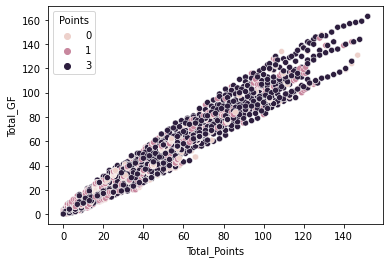

In [24]:
sns.scatterplot(df1.Total_Points,df1.Total_GF,hue=df1.Points)

<AxesSubplot:xlabel='Total_Points', ylabel='Total_GA'>

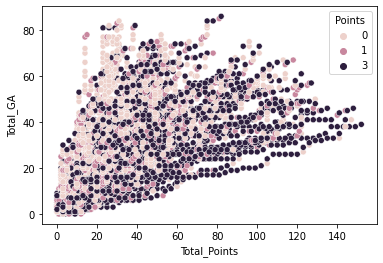

In [25]:
sns.scatterplot(df1.Total_Points,df1.Total_GA,hue=df1.Points)

In [28]:
df2 = Feature_Engineering(df=df1)

In [29]:
df2

,Unnamed: 0,Date,Time,Comp,Round,Day,Venue,Result,GF,GA,Opponent,xG,xGA,Poss,Attendance,Captain,Formation,Referee,Match Report,Notes,Team,Season,Month,Win,Draw,Lose,Points,Total_Points,Total_GF,Total_GA,Total_Win,Total_Draw,Total_Loss,Points_Avg_for_szn,GF_Avg_for_szn,GA_Avg_for_szn,Win_Avg_for_szn,Draw_Avg_for_szn,Loss_Avg_for_szn,Away_Win,Away_Draw,Away_Loss,Home_Win,Home_Draw,Home_Loss,Points_last_1gm_sum,Win_last_1gm_sum,Draw_last_1gm_sum,Lose_last_1gm_sum,GF_last_1gm_sum,GA_last_1gm_sum,Away_Win_last_1gm_sum,Away_Draw_last_1gm_sum,Away_Loss_last_1gm_sum,Home_Win_last_1gm_sum,Home_Draw_last_1gm_sum,Home_Loss_last_1gm_sum,Points_last_2gm_sum,Win_last_2gm_sum,Draw_last_2gm_sum,Lose_last_2gm_sum,GF_last_2gm_sum,GA_last_2gm_sum,Away_Win_last_2gm_sum,Away_Draw_last_2gm_sum,Away_Loss_last_2gm_sum,Home_Win_last_2gm_sum,Home_Draw_last_2gm_sum,Home_Loss_last_2gm_sum,Points_last_3gm_mean,Win_last_3gm_mean,Draw_last_3gm_mean,Lose_last_3gm_mean,GF_last_3gm_mean,GA_last_3gm_mean,Away_Win_last_3gm_mean,Away_Draw_last_3gm_mean,Away_Loss_last_3gm_mean,Home_Win_last_3gm_mean,Home_Draw_last_3gm_mean,Home_Loss_last_3gm_mean,Poss_last_3gm_mean,Rest,Played_Opp_X_times,GF_this_month_sum,GA_this_month_sum,Away_Win_this_month_sum,Away_Draw_this_month_sum,Away_Loss_this_month_sum,Home_Win_this_month_sum,Home_Draw_this_month_sum,Home_Loss_this_month_sum,GF_sum_prev_month_,GA_sum_prev_month_,Away_Win_sum_prev_month_,Away_Draw_sum_prev_month_,Away_Loss_sum_prev_month_,Home_Win_sum_prev_month_,Home_Draw_sum_prev_month_,Home_Loss_sum_prev_month_,GF_this_month_mean,GA_this_month_mean,GF_mean_prev_month_,GA_mean_prev_month_,Poss_this_month_mean,Poss_mean_prev_month_,Captain_Rank,Poss_this_Venue_mean,GF_this_Venue_mean,GA_this_Venue_mean,Win_this_Venue_sum,Lose_this_Venue_sum,Draw_this_Venue_sum,GF_this_Venue_sum,GA_this_Venue_sum,Poss_this_Formation_mean,GF_this_Formation_mean,GA_this_Formation_mean,Win_this_Formation_sum,Lose_this_Formation_sum,Draw_this_Formation_sum,GF_this_Formation_sum,GA_this_Formation_sum,Poss_this_Opp_mean,GA_this_Opp_mean,GF_this_Opp_mean,Win_this_Opp_sum,Lose_this_Opp_sum,Draw_this_Opp_sum,GA_this_Opp_sum,GF_this_Opp_sum,First_Match_In_Month,First_Match_With_Formation,Matches_Played,Opponent_Count,Top7_Opp,Top7_Team,Top4_Opp,Top4_Team,Referee_Count,top20_Ref,top5_Ref,Ref_rank,Prev_comp,Prev_Opp,Captain_Count,Win_this_Comp_sum,Lose_this_Comp_sum,Draw_this_Comp_sum,GF_this_Comp_sum,GA_this_Comp_sum,Away_Win_this_Comp_sum,Away_Draw_this_Comp_sum,Away_Loss_this_Comp_sum,Home_Win_this_Comp_sum,Home_Draw_this_Comp_sum,Home_Loss_this_Comp_sum,Win_this_7_Opp_sum,Lose_this_7_Opp_sum,Draw_this_7_Opp_sum,GF_this_7_Opp_sum,GA_this_7_Opp_sum,Away_Win_this_7_Opp_sum,Away_Draw_this_7_Opp_sum,Away_Loss_this_7_Opp_sum,Home_Win_this_7_Opp_sum,Home_Draw_this_7_Opp_sum,Home_Loss_this_7_Opp_sum,Win_this_4_Opp_sum,Lose_this_4_Opp_sum,Draw_this_4_Opp_sum,GF_this_4_Opp_sum,GA_this_4_Opp_sum,Away_Win_this_4_Opp_sum,Away_Draw_this_4_Opp_sum,Away_Loss_this_4_Opp_sum,Home_Win_this_4_Opp_sum,Home_Draw_this_4_Opp_sum,Home_Loss_this_4_Opp_sum,Win_this_Ref_sum,Lose_this_Ref_sum,Draw_this_Ref_sum,GF_this_Ref_sum,GA_this_Ref_sum,Poss_this_Comp_mean,GF_this_Comp_mean,GA_this_Comp_mean,Win_this_Comp_mean,Lose_this_Comp_mean,Poss_this_7_Opp_mean,GF_this_7_Opp_mean,GA_this_7_Opp_mean,Win_this_7_Opp_mean,Lose_this_7_Opp_mean,Draw_this_7_Opp_mean,Poss_this_Ref_rank_mean,GF_this_Ref_rank_mean,GA_this_Ref_rank_mean,Win_this_Ref_rank_mean,Lose_this_Ref_rank_mean,Draw_this_Ref_rank_mean,Comp_code,Day_code,Venue_code,Opponent_code,Captain_code,Formation_code,Referee_code,Team_code,Prev_comp_code,Prev_Opp_code,Cyclic_Month,Na_count
0,0,2017-08-06,14.00,Community Shield,FA Community Shield,Sun,Neutral,D,1,1,Chelsea,NaN,NaN,NaN,83325.0,Per Mertesacker,3-4-3,Robert Madley,Match Report,NaN,Arsenal,2018,8,0,1,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [65]:
a= pd.DataFrame(df2.groupby(['Top4_Team','Top4_Opp','Ref_rank','Result'])['Result'].agg('count'))

In [66]:
a.tail()

Result
Top4_Team Top4_Opp Ref_rank Result        
1         1        7.5      L            9
                            W            9
                   8.0      D            3
                            L            8
                            W           12

,Notes,Attendance,xG,xGA,Poss_mean_prev_month_,Away_Draw_sum_prev_month_,GF_mean_prev_month_,Home_Loss_sum_prev_month_,Home_Draw_sum_prev_month_,Home_Win_sum_prev_month_,Away_Loss_sum_prev_month_,Away_Win_sum_prev_month_,GA_sum_prev_month_,GF_sum_prev_month_,GA_mean_prev_month_,Poss_last_3gm_mean,Away_Win_last_3gm_mean,Away_Draw_last_3gm_mean,Away_Loss_last_3gm_mean,GF_last_3gm_mean,Lose_last_3gm_mean,Draw_last_3gm_mean,Win_last_3gm_mean,Home_Win_last_3gm_mean,Points_last_3gm_mean,Home_Draw_last_3gm_mean,Home_Loss_last_3gm_mean,GA_last_3gm_mean,Poss_this_Opp_mean,GA_this_Opp_sum,GA_this_Opp_mean,Draw_this_Opp_sum,Lose_this_Opp_sum,Win_this_Opp_sum,GF_this_Opp_mean,GF_this_Opp_sum,Poss_this_Formation_mean,Draw_this_Formation_sum,GF_this_Formation_mean,GA_this_Formation_mean,Win_this_Formation_sum,GF_this_Formation_sum,GA_this_Formation_sum,Lose_this_Formation_sum,Away_Loss_last_2gm_sum,Away_Draw_last_2gm_sum,Home_Draw_last_2gm_sum,Away_Win_last_2gm_sum,Points_last_2gm_sum,Draw_last_2gm_sum,Lose_last_2gm_sum,Home_Win_last_2gm_sum,Win_last_2gm_sum,Home_Loss_last_2gm_sum,GA_last_2gm_sum,GF_last_2gm_sum,Poss_this_Ref_rank_mean,GF_this_Ref_rank_mean,GA_this_Ref_rank_mean,Win_this_Ref_rank_mean,Lose_this_Ref_rank_mean,Draw_this_Ref_rank_mean,Win_this_Ref_sum,Lose_this_Ref_sum,Draw_this_Ref_sum,GF_this_Ref_sum,GA_this_Ref_sum,Ref_rank,Home_Loss_last_1gm_sum,Win_last_1gm_sum,Rest,Home_Draw_last_1gm_sum,Points_last_1gm_sum,Draw_last_1gm_sum,Lose_last_1gm_sum,GF_last_1gm_sum,GA_last_1gm_sum,Away_Win_last_1gm_sum,Away_Draw_last_1gm_sum,Away_Loss_last_1gm_sum,Home_Win_last_1gm_sum,Poss,Away_Loss_this_month_sum,GF_this_month_mean,Poss_this_month_mean,Home_Loss_this_month_sum,Home_Draw_this_month_sum,Home_Win_this_month_sum,GA_this_month_mean,Away_Draw_this_month_sum,Away_Win_this_month_sum,GA_this_month_sum,GF_this_month_sum,GF_this_Venue_sum,Draw_this_Venue_sum,Lose_this_Venue_sum,Win_this_Venue_sum,GA_this_Venue_mean,GF_this_Venue_mean,Poss_this_Venue_mean,GA_this_Venue_sum,Poss_this_Comp_mean,Home_Loss_this_Comp_sum,Home_Draw_this_Comp_sum,Win_this_Comp_mean,GA_this_Comp_mean,GF_this_Comp_mean,Home_Win_this_Comp_sum,Away_Loss_this_Comp_sum,Away_Draw_this_Comp_sum,Away_Win_this_Comp_sum,GA_this_Comp_sum,Win_this_Comp_sum,Lose_this_Comp_sum,Lose_this_Comp_mean,Draw_this_Comp_sum,GF_this_Comp_sum,Captain_Count,Prev_Opp,Prev_comp,Referee_Count
Total,4491.000000,1101.000000,698.000000,698.000000,432.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,361.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,291.000000,265.000000,265.000000,265.000000,265.000000,265.000000,265.000000,265.000000,219.000000,216.000000,216.000000,216.000000,216.000000,216.000000,216.000000,216.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,181.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,31.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,10.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,2.000000,1.000000,1.000000,1.000000
Percent,93.895045,23.019026,14.593351,14.593351,9.031988,8.802007,8.802007,8.802007,8.802007,8.802007,8.802007,8.802007,8.802007,8.802007,8.802007,7.547564,6.272214,6.272214,6.272214,6.272214,6.272214,6.272214,6.272214,6.272214,6.272214,6.272214,6.272214,6.272214,6.084048,5.540456,5.540456,5.540456,5.540456,5.540456,5.540456,5.540456,4.578716,4.51

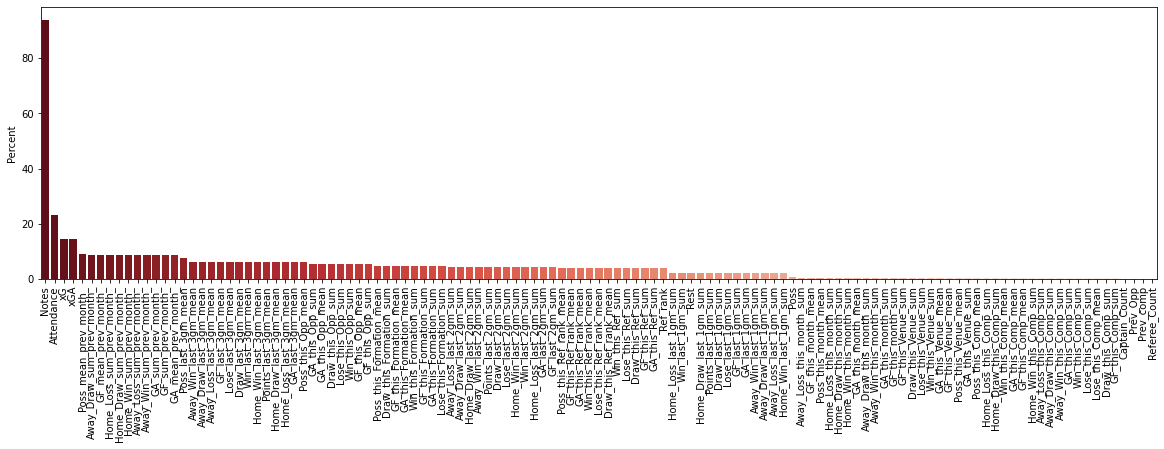

In [127]:
missing = missing_percentage(df2)

fig, ax = plt.subplots(figsize=(20, 5))
sns.barplot(x=missing.index, y='Percent', data=missing, palette='Reds_r')
plt.xticks(rotation=90)

display(missing.T.style.background_gradient(cmap='Reds', axis=1))

In [32]:
drops =['Unnamed: 0','Date','Round','Poss','Attendance','Notes','Attendance','xG','xGA','Match Report']

In [33]:
df3 = df2.drop(drops,axis=1)

,Poss_mean_prev_month_,GF_sum_prev_month_,GA_mean_prev_month_,GF_mean_prev_month_,Home_Loss_sum_prev_month_,Home_Draw_sum_prev_month_,Home_Win_sum_prev_month_,Away_Loss_sum_prev_month_,Away_Draw_sum_prev_month_,Away_Win_sum_prev_month_,GA_sum_prev_month_,Poss_last_3gm_mean,Home_Loss_last_3gm_mean,Away_Win_last_3gm_mean,Points_last_3gm_mean,Win_last_3gm_mean,Draw_last_3gm_mean,Lose_last_3gm_mean,GF_last_3gm_mean,GA_last_3gm_mean,Home_Draw_last_3gm_mean,Home_Win_last_3gm_mean,Away_Loss_last_3gm_mean,Away_Draw_last_3gm_mean,Poss_this_Opp_mean,GA_this_Opp_sum,Win_this_Opp_sum,GF_this_Opp_sum,Lose_this_Opp_sum,GA_this_Opp_mean,GF_this_Opp_mean,Draw_this_Opp_sum,Poss_this_Formation_mean,GF_this_Formation_sum,Win_this_Formation_sum,Lose_this_Formation_sum,GA_this_Formation_sum,Draw_this_Formation_sum,GA_this_Formation_mean,GF_this_Formation_mean,Draw_last_2gm_sum,Home_Draw_last_2gm_sum,Home_Win_last_2gm_sum,Away_Loss_last_2gm_sum,Away_Draw_last_2gm_sum,Away_Win_last_2gm_sum,GA_last_2gm_sum,GF_last_2gm_sum,Lose_last_2gm_sum,Home_Loss_last_2gm_sum,Win_last_2gm_sum,Points_last_2gm_sum,GF_this_Ref_rank_mean,Draw_this_Ref_rank_mean,Lose_this_Ref_rank_mean,GA_this_Ref_sum,Poss_this_Ref_rank_mean,GF_this_Ref_sum,Draw_this_Ref_sum,Lose_this_Ref_sum,Win_this_Ref_sum,Win_this_Ref_rank_mean,GA_this_Ref_rank_mean,Ref_rank,Points_last_1gm_sum,Win_last_1gm_sum,Home_Loss_last_1gm_sum,Home_Win_last_1gm_sum,Away_Loss_last_1gm_sum,Away_Draw_last_1gm_sum,Rest,Away_Win_last_1gm_sum,GA_last_1gm_sum,GF_last_1gm_sum,Lose_last_1gm_sum,Draw_last_1gm_sum,Home_Draw_last_1gm_sum,GA_this_month_mean,GF_this_month_mean,Home_Loss_this_month_sum,Poss_this_month_mean,Away_Draw_this_month_sum,Home_Draw_this_month_sum,Away_Loss_this_month_sum,Away_Win_this_month_sum,GA_this_month_sum,GF_this_month_sum,Home_Win_this_month_sum,Poss_this_Venue_mean,GF_this_Venue_sum,Draw_this_Venue_sum,Lose_this_Venue_sum,Win_this_Venue_sum,GA_this_Venue_mean,GF_this_Venue_mean,GA_this_Venue_sum,Poss_this_Comp_mean,GA_this_Comp_sum,Away_Win_this_Comp_sum,GF_this_Comp_sum,Lose_this_Comp_sum,Win_this_Comp_sum,Home_Win_this_Comp_sum,Home_Draw_this_Comp_sum,Home_Loss_this_Comp_sum,Draw_this_Comp_sum,Away_Draw_this_Comp_sum,Lose_this_Comp_mean,Win_this_Comp_mean,GA_this_Comp_mean,GF_this_Comp_mean,Away_Loss_this_Comp_sum,Captain_Count,Referee_Count,Prev_Opp,Prev_comp
Total,432.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,361.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,291.000000,265.000000,265.000000,265.000000,265.000000,265.000000,265.000000,265.000000,219.000000,216.000000,216.000000,216.000000,216.000000,216.000000,216.000000,216.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,181.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,10.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,2.000000,1.000000,1.000000,1.000000
Percent,9.031988,8.802007,8.802007,8.802007,8.802007,8.802007,8.802007,8.802007,8.802007,8.802007,8.802007,7.547564,6.272214,6.272214,6.272214,6.272214,6.272214,6.272214,6.272214,6.272214,6.272214,6.272214,6.272214,6.272214,6.084048,5.540456,5.540456,5.540456,5.540456,5.540456,5.540456,5.540456,4.578716,4.515994,4.515994,4.515994,4.515994,4.515994,4.515994,4.515994,4.181476,4.181476,4.181476,4.181476,4.181476,4.181476,4.181476,4.1

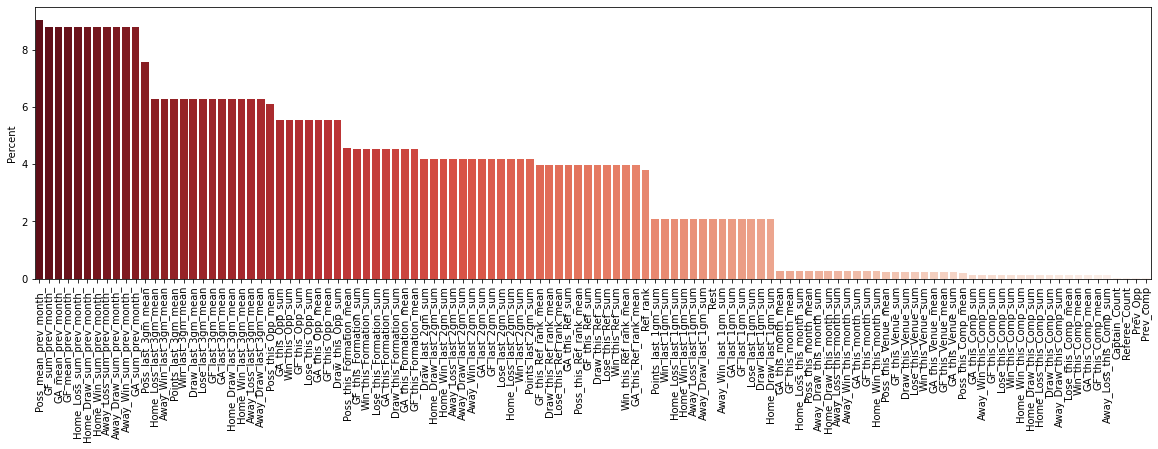

In [138]:
missing = missing_percentage(df3)

fig, ax = plt.subplots(figsize=(20, 5))
sns.barplot(x=missing.index, y='Percent', data=missing, palette='Reds_r')
plt.xticks(rotation=90)

display(missing.T.style.background_gradient(cmap='Reds', axis=1))

In [36]:
df4 = df3.dropna()

In [34]:
df3.shape

(4783, 204)

In [37]:
df4.shape

(3779, 204)

In [22]:
df4

,Time,Comp,Day,Venue,Result,GF,GA,Opponent,Captain,Formation,Referee,Team,Season,Month,Win,Draw,Lose,Points,Total_Points,Total_GF,Total_GA,Total_Win,Total_Draw,Total_Loss,Points_Avg_for_szn,GF_Avg_for_szn,GA_Avg_for_szn,Win_Avg_for_szn,Draw_Avg_for_szn,Loss_Avg_for_szn,Away_Win,Away_Draw,Away_Loss,Home_Win,Home_Draw,Home_Loss,Points_last_1gm_sum,Win_last_1gm_sum,Draw_last_1gm_sum,Lose_last_1gm_sum,GF_last_1gm_sum,GA_last_1gm_sum,Away_Win_last_1gm_sum,Away_Draw_last_1gm_sum,Away_Loss_last_1gm_sum,Home_Win_last_1gm_sum,Home_Draw_last_1gm_sum,Home_Loss_last_1gm_sum,Points_last_2gm_sum,Win_last_2gm_sum,Draw_last_2gm_sum,Lose_last_2gm_sum,GF_last_2gm_sum,GA_last_2gm_sum,Away_Win_last_2gm_sum,Away_Draw_last_2gm_sum,Away_Loss_last_2gm_sum,Home_Win_last_2gm_sum,Home_Draw_last_2gm_sum,Home_Loss_last_2gm_sum,Points_last_3gm_mean,Win_last_3gm_mean,Draw_last_3gm_mean,Lose_last_3gm_mean,GF_last_3gm_mean,GA_last_3gm_mean,Away_Win_last_3gm_mean,Away_Draw_last_3gm_mean,Away_Loss_last_3gm_mean,Home_Win_last_3gm_mean,Home_Draw_last_3gm_mean,Home_Loss_last_3gm_mean,Poss_last_3gm_mean,Rest,Played_Opp_X_times,GF_this_month_sum,GA_this_month_sum,Away_Win_this_month_sum,Away_Draw_this_month_sum,Away_Loss_this_month_sum,Home_Win_this_month_sum,Home_Draw_this_month_sum,Home_Loss_this_month_sum,GF_sum_prev_month_,GA_sum_prev_month_,Away_Win_sum_prev_month_,Away_Draw_sum_prev_month_,Away_Loss_sum_prev_month_,Home_Win_sum_prev_month_,Home_Draw_sum_prev_month_,Home_Loss_sum_prev_month_,GF_this_month_mean,GA_this_month_mean,GF_mean_prev_month_,GA_mean_prev_month_,Poss_this_month_mean,Poss_mean_prev_month_,Captain_Rank,Poss_this_Venue_mean,GF_this_Venue_mean,GA_this_Venue_mean,Win_this_Venue_sum,Lose_this_Venue_sum,Draw_this_Venue_sum,GF_this_Venue_sum,GA_this_Venue_sum,Poss_this_Formation_mean,GF_this_Formation_mean,GA_this_Formation_mean,Win_this_Formation_sum,Lose_this_Formation_sum,Draw_this_Formation_sum,GF_this_Formation_sum,GA_this_Formation_sum,Poss_this_Opp_mean,GA_this_Opp_mean,GF_this_Opp_mean,Win_this_Opp_sum,Lose_this_Opp_sum,Draw_this_Opp_sum,GA_this_Opp_sum,GF_this_Opp_sum,First_Match_In_Month,First_Match_With_Formation,Matches_Played,Opponent_Count,Top7_Opp,Top7_Team,Top4_Opp,Top4_Team,Referee_Count,top20_Ref,top5_Ref,Ref_rank,Prev_comp,Prev_Opp,Captain_Count,Win_this_Comp_sum,Lose_this_Comp_sum,Draw_this_Comp_sum,GF_this_Comp_sum,GA_this_Comp_sum,Away_Win_this_Comp_sum,Away_Draw_this_Comp_sum,Away_Loss_this_Comp_sum,Home_Win_this_Comp_sum,Home_Draw_this_Comp_sum,Home_Loss_this_Comp_sum,Win_this_7_Opp_sum,Lose_this_7_Opp_sum,Draw_this_7_Opp_sum,GF_this_7_Opp_sum,GA_this_7_Opp_sum,Away_Win_this_7_Opp_sum,Away_Draw_this_7_Opp_sum,Away_Loss_this_7_Opp_sum,Home_Win_this_7_Opp_sum,Home_Draw_this_7_Opp_sum,Home_Loss_this_7_Opp_sum,Win_this_4_Opp_sum,Lose_this_4_Opp_sum,Draw_this_4_Opp_sum,GF_this_4_Opp_sum,GA_this_4_Opp_sum,Away_Win_this_4_Opp_sum,Away_Draw_this_4_Opp_sum,Away_Loss_this_4_Opp_sum,Home_Win_this_4_Opp_sum,Home_Draw_this_4_Opp_sum,Home_Loss_this_4_Opp_sum,Win_this_Ref_sum,Lose_this_Ref_sum,Draw_this_Ref_sum,GF_this_Ref_sum,GA_this_Ref_sum,Poss_this_Comp_mean,GF_this_Comp_mean,GA_this_Comp_mean,Win_this_Comp_mean,Lose_this_Comp_mean,Poss_this_7_Opp_mean,GF_this_7_Opp_mean,GA_this_7_Opp_mean,Win_this_7_Opp_mean,Lose_this_7_Opp_mean,Draw_this_7_Opp_mean,Poss_this_Ref_rank_mean,GF_this_Ref_rank_mean,GA_this_Ref_rank_mean,Win_this_Ref_rank_mean,Lose_this_Ref_rank_mean,Draw_this_Ref_rank_mean,Comp_code,Day_code,Venue_code,Opponent_code,Captain_code,Formation_code,Referee_code,Team_code,Cyclic_Month,Na_count
4,15.00,Premier League,Sat,Home,W,3,0,Bournemouth,Laurent Koscielny,3-4-3,Anthony Taylor,Arsenal,2018,9,1,0,0,3,4.0,5.0,9.0,1.0,1.0,2.0,1.000000,1.250000,2.250000,0.250000,0.250000,0.500000,0,0,0,1,0,0,0.0,0.0,0.0,1.0,0.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,5.0,0.0,0.0,2.0,0.0,0.0,0.0,1.000000,0.333333,0.000000,0.666667,1.333333,2.666667,0.000000,0.000000,0.666667,0.333333,0.000000,0.000000,65.333333,13.0,0,6.2,0.800000,0.0,

### Win Ratio ,Draw Ratio , Lose Ratio

In [87]:
df4.Points.value_counts()/df4.shape[0]

3    0.405398
0    0.368087
1    0.226515
Name: Points, dtype: float64

In [44]:
from sklearn.ensemble import RandomForestClassifier

In [39]:
rf = RandomForestClassifier(n_estimators=200, min_samples_split=10, random_state=1)

In [42]:
cats = df4[predictors].select_dtypes(include='object').columns

In [43]:
cats

Index([], dtype='object')

In [40]:
predictors = df4.columns.drop([ 'Result',
 'GF',
 'GA', 'Win',
 'Draw',
 'Lose',
 'Points', 'Away_Win',
 'Away_Draw',
 'Away_Loss',
 'Home_Win',
 'Home_Draw',
 'Home_Loss','Result','Comp','Day','Venue','Opponent','Captain','Formation','Referee','Team','Prev_comp', 'Prev_Opp'])

In [49]:
rf.fit(train[predictors], train["Win"])

RandomForestClassifier(min_samples_split=10, n_estimators=200, random_state=1)

In [50]:
preds = rf.predict(test[predictors])

In [51]:
from sklearn.metrics import accuracy_score

In [52]:
error = accuracy_score(test["Win"], preds)

In [53]:
error

0.775235531628533

In [186]:
combined = pd.DataFrame(dict(actual=test["Win"], predicted=preds))

In [187]:
pd.crosstab(index=combined["actual"], columns=combined["predicted"])

predicted,0,1
actual,,
0,363,84
1,82,214


In [118]:
df5

,Time,Comp,Day,Venue,Result,GF,GA,Opponent,Captain,Formation,Referee,Team,Season,Month,Win,Draw,Lose,Points,Total_Points,Total_GF,Total_GA,Total_Win,Total_Draw,Total_Loss,Points_Avg_for_szn,GF_Avg_for_szn,GA_Avg_for_szn,Win_Avg_for_szn,Draw_Avg_for_szn,Loss_Avg_for_szn,Away_Win,Away_Draw,Away_Loss,Home_Win,Home_Draw,Home_Loss,Points_last_1gm_sum,Win_last_1gm_sum,Draw_last_1gm_sum,Lose_last_1gm_sum,GF_last_1gm_sum,GA_last_1gm_sum,Away_Win_last_1gm_sum,Away_Draw_last_1gm_sum,Away_Loss_last_1gm_sum,Home_Win_last_1gm_sum,Home_Draw_last_1gm_sum,Home_Loss_last_1gm_sum,Points_last_2gm_sum,Win_last_2gm_sum,Draw_last_2gm_sum,Lose_last_2gm_sum,GF_last_2gm_sum,GA_last_2gm_sum,Away_Win_last_2gm_sum,Away_Draw_last_2gm_sum,Away_Loss_last_2gm_sum,Home_Win_last_2gm_sum,Home_Draw_last_2gm_sum,Home_Loss_last_2gm_sum,Points_last_3gm_mean,Win_last_3gm_mean,Draw_last_3gm_mean,Lose_last_3gm_mean,GF_last_3gm_mean,GA_last_3gm_mean,Away_Win_last_3gm_mean,Away_Draw_last_3gm_mean,Away_Loss_last_3gm_mean,Home_Win_last_3gm_mean,Home_Draw_last_3gm_mean,Home_Loss_last_3gm_mean,Poss_last_3gm_mean,Rest,Played_Opp_X_times,GF_this_month_sum,GA_this_month_sum,Away_Win_this_month_sum,Away_Draw_this_month_sum,Away_Loss_this_month_sum,Home_Win_this_month_sum,Home_Draw_this_month_sum,Home_Loss_this_month_sum,GF_sum_prev_month_,GA_sum_prev_month_,Away_Win_sum_prev_month_,Away_Draw_sum_prev_month_,Away_Loss_sum_prev_month_,Home_Win_sum_prev_month_,Home_Draw_sum_prev_month_,Home_Loss_sum_prev_month_,GF_this_month_mean,GA_this_month_mean,GF_mean_prev_month_,GA_mean_prev_month_,Poss_this_month_mean,Poss_mean_prev_month_,Captain_Rank,Poss_this_Venue_mean,GF_this_Venue_mean,GA_this_Venue_mean,Win_this_Venue_sum,Lose_this_Venue_sum,Draw_this_Venue_sum,GF_this_Venue_sum,GA_this_Venue_sum,Poss_this_Formation_mean,GF_this_Formation_mean,GA_this_Formation_mean,Win_this_Formation_sum,Lose_this_Formation_sum,Draw_this_Formation_sum,GF_this_Formation_sum,GA_this_Formation_sum,Poss_this_Opp_mean,GA_this_Opp_mean,GF_this_Opp_mean,Win_this_Opp_sum,Lose_this_Opp_sum,Draw_this_Opp_sum,GA_this_Opp_sum,GF_this_Opp_sum,First_Match_In_Month,First_Match_With_Formation,Matches_Played,Opponent_Count,Top7_Opp,Top7_Team,Top4_Opp,Top4_Team,Referee_Count,top20_Ref,top5_Ref,Ref_rank,Prev_comp,Prev_Opp,Captain_Count,Win_this_Comp_sum,Lose_this_Comp_sum,Draw_this_Comp_sum,GF_this_Comp_sum,GA_this_Comp_sum,Away_Win_this_Comp_sum,Away_Draw_this_Comp_sum,Away_Loss_this_Comp_sum,Home_Win_this_Comp_sum,Home_Draw_this_Comp_sum,Home_Loss_this_Comp_sum,Win_this_7_Opp_sum,Lose_this_7_Opp_sum,Draw_this_7_Opp_sum,GF_this_7_Opp_sum,GA_this_7_Opp_sum,Away_Win_this_7_Opp_sum,Away_Draw_this_7_Opp_sum,Away_Loss_this_7_Opp_sum,Home_Win_this_7_Opp_sum,Home_Draw_this_7_Opp_sum,Home_Loss_this_7_Opp_sum,Win_this_4_Opp_sum,Lose_this_4_Opp_sum,Draw_this_4_Opp_sum,GF_this_4_Opp_sum,GA_this_4_Opp_sum,Away_Win_this_4_Opp_sum,Away_Draw_this_4_Opp_sum,Away_Loss_this_4_Opp_sum,Home_Win_this_4_Opp_sum,Home_Draw_this_4_Opp_sum,Home_Loss_this_4_Opp_sum,Win_this_Ref_sum,Lose_this_Ref_sum,Draw_this_Ref_sum,GF_this_Ref_sum,GA_this_Ref_sum,Poss_this_Comp_mean,GF_this_Comp_mean,GA_this_Comp_mean,Win_this_Comp_mean,Lose_this_Comp_mean,Poss_this_7_Opp_mean,GF_this_7_Opp_mean,GA_this_7_Opp_mean,Win_this_7_Opp_mean,Lose_this_7_Opp_mean,Draw_this_7_Opp_mean,Poss_this_Ref_rank_mean,GF_this_Ref_rank_mean,GA_this_Ref_rank_mean,Win_this_Ref_rank_mean,Lose_this_Ref_rank_mean,Draw_this_Ref_rank_mean,Comp_code,Day_code,Venue_code,Opponent_code,Captain_code,Formation_code,Referee_code,Team_code,Cyclic_Month,Na_count,Prev_comp_code,Prev_Opp_code
4,15.00,Premier League,Sat,Home,W,3,0,Bournemouth,Laurent Koscielny,3-4-3,Anthony Taylor,Arsenal,2018,9,1,0,0,3,4.0,5.0,9.0,1.0,1.0,2.0,1.000000,1.250000,2.250000,0.250000,0.250000,0.500000,0,0,0,1,0,0,0.0,0.0,0.0,1.0,0.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,5.0,0.0,0.0,2.0,0.0,0.0,0.0,1.000000,0.333333,0.000000,0.666667,1.333333,2.666667,0.000000,0.000000,0.666667,0.333333,0.000000,0.000000,65.33

In [188]:
from sklearn.metrics import precision_score

precision_score(test["Win"], preds)

0.7181208053691275

In [158]:
def model_feature_importance(model,X_train_df,n_features):
    feature_importance_df = pd.DataFrame(model.feature_importances_,columns=['importance'])
    feature_importance_df['feature'] = X_train_df.columns
    new_feat= feature_importance_df.sort_values(by=['importance'],ascending= False).head(n_features)['feature'].to_list()
    plt.figure(figsize=(20,14))
    sns.barplot(x='importance',y='feature',data=feature_importance_df.sort_values(by=['importance'],ascending= False).head(n_features))
    plt.title('Model__Feature__Importance')
    plt.show()
    return new_feat

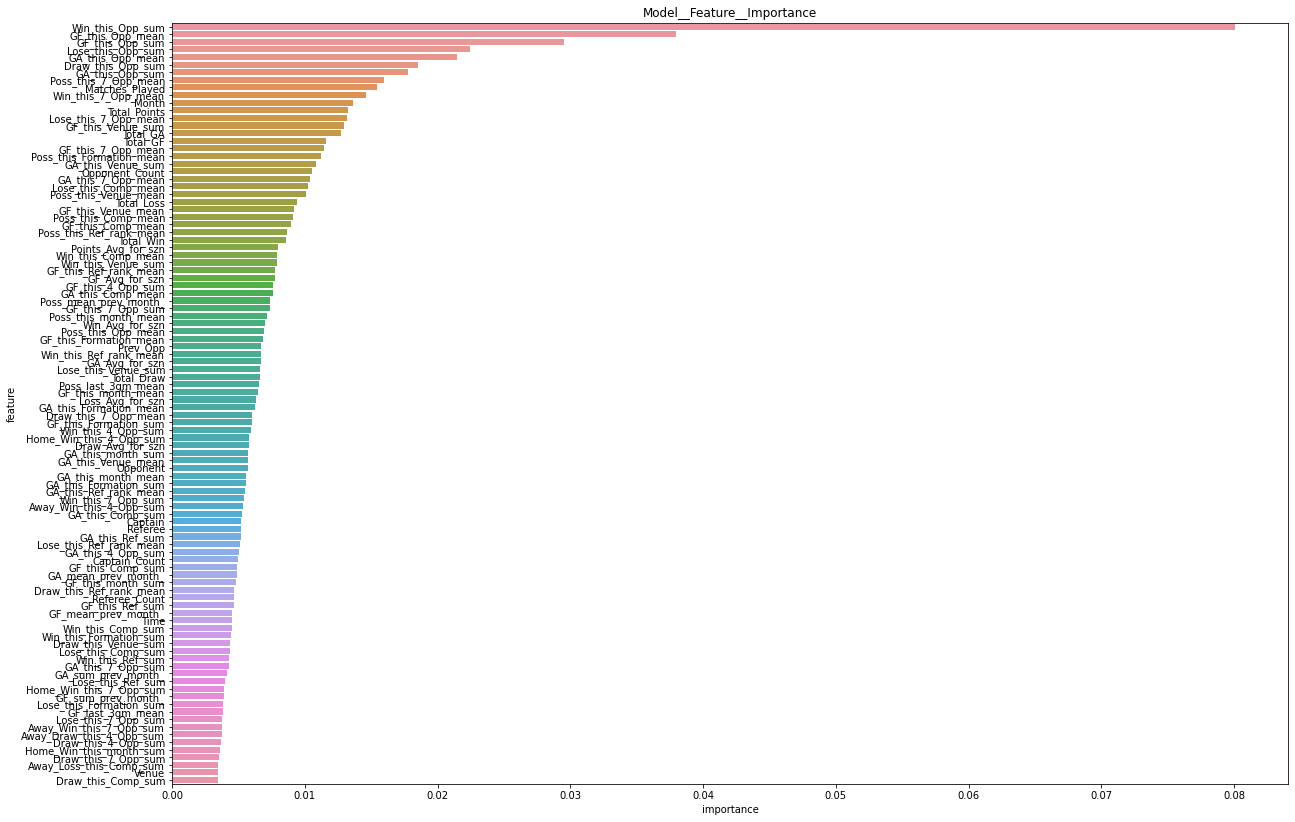

In [193]:
feat100 = model_feature_importance(model=rf,X_train_df=train[predictors],n_features=100)

In [194]:
rf.fit(train[feat100], train["Win"])

RandomForestClassifier(min_samples_split=10, n_estimators=200, random_state=1)

In [195]:
preds = rf.predict(test[feat100])

In [197]:
error = accuracy_score(test["Win"], preds)
error

0.7711978465679677

In [198]:
combined = pd.DataFrame(dict(actual=test["Win"], predicted=preds))

In [199]:
pd.crosstab(index=combined["actual"], columns=combined["predicted"])

predicted,0,1
actual,,
0,364,83
1,87,209


In [200]:
precision_score(test["Win"], preds)

0.7157534246575342

In [ ]:
    if robust == True:
        Robustscaler = RobustScaler()
        Robustscaler.fit(train_df)
        train_df = pd.DataFrame(Robustscaler.transform(train_df), index=train_df.index, columns=train_df.columns)
        test_df = pd.DataFrame(Robustscaler.transform(test_df), index=test_df.index, columns=test_df.columns)
        
    if standard == True:
        Standardscaler = StandardScaler()
        Standardscaler.fit(train_df)
        train_df = pd.DataFrame(Standardscaler.transform(train_df), index=train_df.index, columns=train_df.columns)
        test_df = pd.DataFrame(Standardscaler.transform(test_df), index=test_df.index, columns=test_df.columns)

In [206]:
train_scaled ,test_scaled = scale_dataframe(train[predictors],test[predictors],robust = True ,standard = False)

No inf values in train_df: True
No inf values in test_df:True


In [207]:
rf.fit(train_scaled[predictors], train["Win"])

RandomForestClassifier(min_samples_split=10, n_estimators=200, random_state=1)

In [210]:
preds = rf.predict(test_scaled[predictors])

In [211]:
error = accuracy_score(test["Win"], preds)
error

0.7779273216689099

In [212]:
combined = pd.DataFrame(dict(actual=test["Win"], predicted=preds))

In [213]:
pd.crosstab(index=combined["actual"], columns=combined["predicted"])

predicted,0,1
actual,,
0,362,85
1,80,216


In [214]:
precision_score(test["Win"], preds)

0.717607973421927

In [47]:
def predictions(data,predictors,targets,model):
    data = data.copy()
    train = data[data["Season"] < 2022]
    test = data[data["Season"] == 2022]
    combination = []
    for target in targets:
        model.fit(train[predictors], train[target])
        preds = model.predict_proba(test[predictors])[:,1]
        preds = pd.Series(preds, index=test.index)
        preds[preds > .6] = 1
        preds[preds<=.6] = 0
        error = accuracy_score(test[target], preds)
        print(f"{target} Accuracy Score : ",error)
        print()
        col ="predicted_"+target
        combined = pd.DataFrame(dict(actual=test[target], predicted=preds))
        combined.columns = ['actual',col]
        combination.append(combined) 
        display(pd.crosstab(index=combined["actual"], columns=combined[col]))
        if target == 'Points':
            print(f"{target} Precision _Macro_Micro : ",precision_score(test[target], preds, average = 'macro'),precision_score(test[target], preds, average = 'micro'))# print("Precision : ",precision_score(test[target], preds))
            print(f"{target} F1_score _Macro_Micro : ",f1_score(test[target], preds, average = 'macro'),f1_score(test[target], preds, average = 'micro'))
            #print(f"{target} ROC _Macro_Micro : ",roc_auc_score(test[target], preds, average = 'macro'),roc_auc_score(test[target], preds, average = 'micro'))
        else:
            print(f"{target} Precision : ",precision_score(test[target], preds))
            print(f"{target} F1_score : ",f1_score(test[target], preds))
            print(f"{target} ROC : ",roc_auc_score(test[target], preds))
        print()
        print()
    combinations = pd.concat(combination,axis=1)
    combinations = combinations.merge(test[["Team", "Opponent", "Result"]], left_index=True, right_index=True)
    return combinations

In [83]:
first_batch = predictions(data=df5,predictors=predictors,targets=['Win','Draw','Lose','Points'])

Win Accuracy Score :  0.7577388963660835



predicted_Win,0.0,1.0
actual,,
0,423,24
1,156,140


Win Precision :  0.8536585365853658
Win F1_score :  0.6086956521739131
Win ROC :  0.7096408489025939


Draw Accuracy Score :  0.8425302826379543



predicted_Draw,0.0,1.0
actual,,
0,568,2
1,115,58


Draw Precision :  0.9666666666666667
Draw F1_score :  0.49785407725321884
Draw ROC :  0.6658756718385559


Lose Accuracy Score :  0.7819650067294751



predicted_Lose,0.0,1.0
actual,,
0,458,11
1,151,123


Lose Precision :  0.917910447761194
Lose F1_score :  0.6029411764705882
Lose ROC :  0.7127254758532675


Points Accuracy Score :  0.414535666218035



predicted_Points,0.0,1.0
actual,,
0,274,0
1,139,34
3,296,0


Points Precision _Macro_Micro :  0.462153267512929 0.414535666218035
Points F1_score _Macro_Micro :  0.29532650878132766 0.414535666218035




In [85]:
b

,actual,predicted_Win,actual,predicted_Draw,actual,predicted_Lose,actual,predicted_Points,Team,Opponent,Result
4048,1,1.0,0,0.0,0,0.0,3,0.0,Chelsea,Aston Villa,W
4049,1,1.0,0,0.0,0,0.0,3,0.0,Chelsea,twos,W
4050,1,1.0,0,0.0,0,0.0,3,0.0,Chelsea,Tottenham,W
4051,0,1.0,1,0.0,0,0.0,1,0.0,Chelsea,Aston Villa,D
4052,0,0.0,0,0.0,1,1.0,0,0.0,Chelsea,Manchester City,L
4053,0,0.0,0,0.0,1,0.0,0,0.0,Chelsea,sixs,L
4054,1,1.0,0,0.0,0,0.0,3,0.0,Chelsea,Southampton,W
4055,1,1.0,0,0.0,0,0.0,3,0.0,Chelsea,Brentford,W
4056,1,1.0,0,0.0,0,0.0,3,0.0,Chelsea,fours,W
4057,1,1.0,0,0.0,0,0.0,3,0.0,Chelsea,Norwich City,W


In [48]:
rf1000 = RandomForestClassifier(n_estimators=1000, min_samples_split=10, random_state=1)

In [51]:
second_batch = predictions(data= df4,predictors = predictors,targets=['Win','Draw','Lose','Points'],model=rf1000)

Win Accuracy Score :  0.7631224764468372



predicted_Win,0.0,1.0
actual,,
0,427,20
1,156,140


Win Precision :  0.875
Win F1_score :  0.6140350877192983
Win ROC :  0.7141151218332427


Draw Accuracy Score :  0.8411843876177658



predicted_Draw,0.0,1.0
actual,,
0,568,2
1,116,57


Draw Precision :  0.9661016949152542
Draw F1_score :  0.49137931034482757
Draw ROC :  0.6629854984281514


Lose Accuracy Score :  0.7792732166890982



predicted_Lose,0.0,1.0
actual,,
0,459,10
1,154,120


Lose Precision :  0.9230769230769231
Lose F1_score :  0.594059405940594
Lose ROC :  0.7083171213795464


Points Accuracy Score :  0.4226110363391655



predicted_Points,0.0,1.0
actual,,
0,274,0
1,133,40
3,296,0


Points Precision _Macro_Micro :  0.46325272641062115 0.4226110363391655
Points F1_score _Macro_Micro :  0.3121625236463705 0.4226110363391655




In [52]:
second_batch

,actual,predicted_Win,actual,predicted_Draw,actual,predicted_Lose,actual,predicted_Points,Team,Opponent,Result
3833,1,1.0,0,0.0,0,0.0,3,0.0,Arsenal,Norwich City,W
3834,1,1.0,0,0.0,0,0.0,3,0.0,Arsenal,Burnley,W
3836,1,1.0,0,0.0,0,0.0,3,0.0,Arsenal,Tottenham,W
3837,0,0.0,1,1.0,0,0.0,1,1.0,Arsenal,Brighton,D
3838,0,0.0,1,1.0,0,0.0,1,1.0,Arsenal,Crystal Palace,D
...,...,...,...,...,...,...,...,...,...,...,...
4778,0,0.0,0,0.0,1,0.0,0,0.0,Wolverhampton Wanderers,Brighton,L
4779,0,0.0,1,0.0,0,0.0,1,0.0,Wolverhampton Wanderers,Chelsea,D
4780,0,0.0,0,0.0,1,1.0,0,0.0,Wolverhampton Wanderers,Manchester City,L
4781,0,0.0,1,0.0,0,0.0,1,0.0,Wolverhampton Wanderers,Norwich City,D


In [53]:
second_batch[second_batch.Team == 'Chelsea']

,actual,predicted_Win,actual,predicted_Draw,actual,predicted_Lose,actual,predicted_Points,Team,Opponent,Result
4048,1,1.0,0,0.0,0,0.0,3,0.0,Chelsea,Aston Villa,W
4049,1,1.0,0,0.0,0,0.0,3,0.0,Chelsea,twos,W
4050,1,1.0,0,0.0,0,0.0,3,0.0,Chelsea,Tottenham,W
4051,0,1.0,1,0.0,0,0.0,1,0.0,Chelsea,Aston Villa,D
4052,0,0.0,0,0.0,1,1.0,0,0.0,Chelsea,Manchester City,L
4053,0,0.0,0,0.0,1,0.0,0,0.0,Chelsea,sixs,L
4054,1,1.0,0,0.0,0,0.0,3,0.0,Chelsea,Southampton,W
4055,1,1.0,0,0.0,0,0.0,3,0.0,Chelsea,Brentford,W
4056,1,1.0,0,0.0,0,0.0,3,0.0,Chelsea,fours,W
4057,1,1.0,0,0.0,0,0.0,3,0.0,Chelsea,Norwich City,W


In [54]:
Robustscaler = RobustScaler()
X_scaled = Robustscaler.fit_transform(df4[predictors])

In [56]:
X_scaled.shape

(3779, 181)

In [58]:
pca = PCA(n_components=2)

In [59]:
pca.fit(X_scaled)

PCA(n_components=2)

In [60]:
pca.explained_variance_ratio_

array([0.22093671, 0.12365846])

In [61]:
transformed = pca.transform(X_scaled)

In [62]:
transformed.shape

(3779, 2)

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

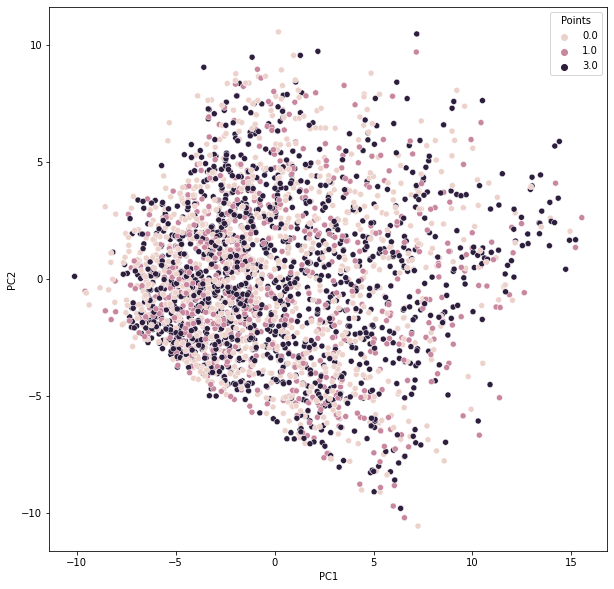

In [66]:
principal_df = pd.DataFrame(data= transformed ,columns = ['PC1','PC2'])

fig,ax = plt.subplots(figsize=(10,10))
sns.scatterplot(x= principal_df['PC1'],y=principal_df['PC2'],hue = df4.Points)

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

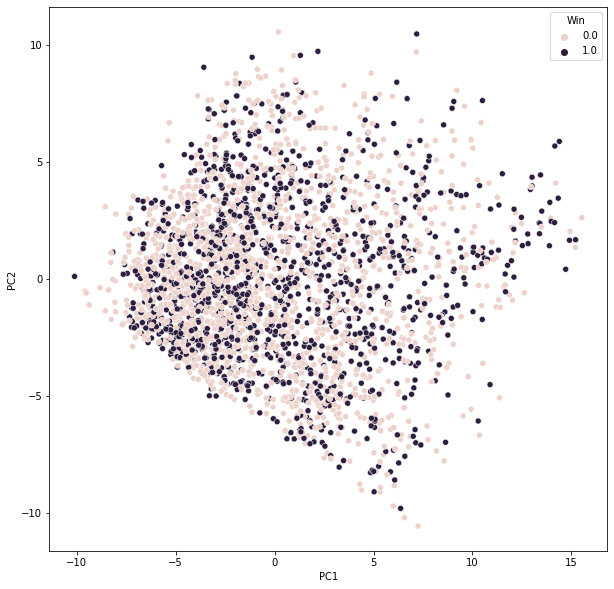

In [68]:
fig,ax = plt.subplots(figsize=(10,10))
sns.scatterplot(x= principal_df['PC1'],y=principal_df['PC2'],hue = df4.Win)

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

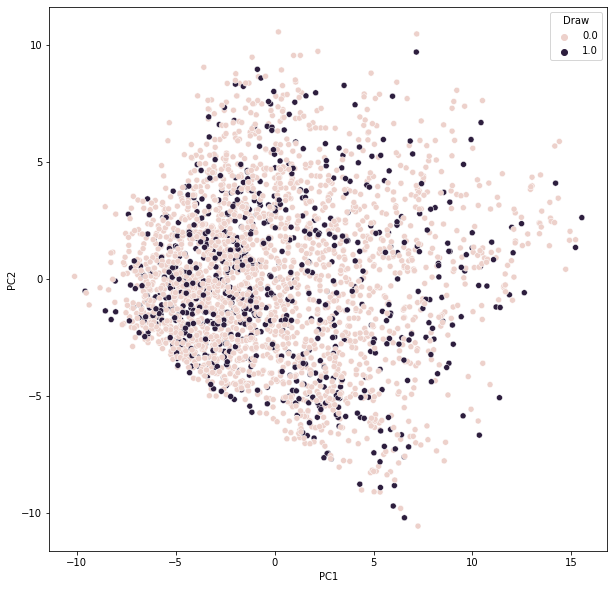

In [69]:
fig,ax = plt.subplots(figsize=(10,10))
sns.scatterplot(x= principal_df['PC1'],y=principal_df['PC2'],hue = df4.Draw)

In [70]:
b

In [71]:
pca_3 = PCA(n_components=3)
X_pca = pca_3.fit_transform(X_scaled) 

In [72]:
pca_3.explained_variance_ratio_

array([0.22093671, 0.12365846, 0.05333454])

In [82]:
principal_df3 = pd.DataFrame(data= X_pca ,columns = ['PC1','PC2','PC3'])
principal_df3.loc[:,'Points'] = df4.Points.values

In [81]:
df4.Points.isna().sum()

0

In [83]:
principal_df3

,PC1,PC2,PC3,Points
0,-3.866734,-3.706260,-0.989078,3
1,-1.702173,-5.228754,-2.390903,1
2,0.216399,-6.150700,-2.363811,3
3,0.662201,-6.442003,-2.144148,3
4,0.824501,-6.560584,-1.941773,0
...,...,...,...,...
3774,0.717851,4.700353,0.386859,0
3775,-2.679361,2.215033,1.631067,1
3776,-1.617528,3.508939,1.266899,0
3777,-0.059001,5.535735,2.466049,1


In [84]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib qt

fig = plt.figure(figsize=(20,20))

ax = plt.axes(projection = '3d')

points = df4.Points.unique()
colors = ['g','b','r']

for result,color in zip(points,colors):
    indicesToKeep = principal_df3['Points'] == result
    ax.scatter3D(principal_df3.loc[indicesToKeep,'PC1'],
                principal_df3.loc[indicesToKeep,'PC2'],
                principal_df3.loc[indicesToKeep,'PC3'],
                c=color,
                s=50)
    
ax.legend(df4.Points.unique())

#plotting
ax.set_xlabel('PC1',fontsize=15)
ax.set_ylabel('PC2',fontsize=15)
ax.set_zlabel('PC3',fontsize=15)

ax.set_title('3D PCA')
ax.view_init(45,90)

plt.show()



In [88]:
df4.head()

,Time,Comp,Day,Venue,Result,GF,GA,Opponent,Captain,Formation,Referee,Team,Season,Month,Win,Draw,Lose,Points,Total_Points,Total_GF,Total_GA,Total_Win,Total_Draw,Total_Loss,Points_Avg_for_szn,GF_Avg_for_szn,GA_Avg_for_szn,Win_Avg_for_szn,Draw_Avg_for_szn,Loss_Avg_for_szn,Away_Win,Away_Draw,Away_Loss,Home_Win,Home_Draw,Home_Loss,Points_last_1gm_sum,Win_last_1gm_sum,Draw_last_1gm_sum,Lose_last_1gm_sum,GF_last_1gm_sum,GA_last_1gm_sum,Away_Win_last_1gm_sum,Away_Draw_last_1gm_sum,Away_Loss_last_1gm_sum,Home_Win_last_1gm_sum,Home_Draw_last_1gm_sum,Home_Loss_last_1gm_sum,Points_last_2gm_sum,Win_last_2gm_sum,Draw_last_2gm_sum,Lose_last_2gm_sum,GF_last_2gm_sum,GA_last_2gm_sum,Away_Win_last_2gm_sum,Away_Draw_last_2gm_sum,Away_Loss_last_2gm_sum,Home_Win_last_2gm_sum,Home_Draw_last_2gm_sum,Home_Loss_last_2gm_sum,Points_last_3gm_mean,Win_last_3gm_mean,Draw_last_3gm_mean,Lose_last_3gm_mean,GF_last_3gm_mean,GA_last_3gm_mean,Away_Win_last_3gm_mean,Away_Draw_last_3gm_mean,Away_Loss_last_3gm_mean,Home_Win_last_3gm_mean,Home_Draw_last_3gm_mean,Home_Loss_last_3gm_mean,Poss_last_3gm_mean,Rest,Played_Opp_X_times,GF_this_month_sum,GA_this_month_sum,Away_Win_this_month_sum,Away_Draw_this_month_sum,Away_Loss_this_month_sum,Home_Win_this_month_sum,Home_Draw_this_month_sum,Home_Loss_this_month_sum,GF_sum_prev_month_,GA_sum_prev_month_,Away_Win_sum_prev_month_,Away_Draw_sum_prev_month_,Away_Loss_sum_prev_month_,Home_Win_sum_prev_month_,Home_Draw_sum_prev_month_,Home_Loss_sum_prev_month_,GF_this_month_mean,GA_this_month_mean,GF_mean_prev_month_,GA_mean_prev_month_,Poss_this_month_mean,Poss_mean_prev_month_,Captain_Rank,Poss_this_Venue_mean,GF_this_Venue_mean,GA_this_Venue_mean,Win_this_Venue_sum,Lose_this_Venue_sum,Draw_this_Venue_sum,GF_this_Venue_sum,GA_this_Venue_sum,Poss_this_Formation_mean,GF_this_Formation_mean,GA_this_Formation_mean,Win_this_Formation_sum,Lose_this_Formation_sum,Draw_this_Formation_sum,GF_this_Formation_sum,GA_this_Formation_sum,Poss_this_Opp_mean,GA_this_Opp_mean,GF_this_Opp_mean,Win_this_Opp_sum,Lose_this_Opp_sum,Draw_this_Opp_sum,GA_this_Opp_sum,GF_this_Opp_sum,First_Match_In_Month,First_Match_With_Formation,Matches_Played,Opponent_Count,Top7_Opp,Top7_Team,Top4_Opp,Top4_Team,Referee_Count,top20_Ref,top5_Ref,Ref_rank,Prev_comp,Prev_Opp,Captain_Count,Win_this_Comp_sum,Lose_this_Comp_sum,Draw_this_Comp_sum,GF_this_Comp_sum,GA_this_Comp_sum,Away_Win_this_Comp_sum,Away_Draw_this_Comp_sum,Away_Loss_this_Comp_sum,Home_Win_this_Comp_sum,Home_Draw_this_Comp_sum,Home_Loss_this_Comp_sum,Win_this_7_Opp_sum,Lose_this_7_Opp_sum,Draw_this_7_Opp_sum,GF_this_7_Opp_sum,GA_this_7_Opp_sum,Away_Win_this_7_Opp_sum,Away_Draw_this_7_Opp_sum,Away_Loss_this_7_Opp_sum,Home_Win_this_7_Opp_sum,Home_Draw_this_7_Opp_sum,Home_Loss_this_7_Opp_sum,Win_this_4_Opp_sum,Lose_this_4_Opp_sum,Draw_this_4_Opp_sum,GF_this_4_Opp_sum,GA_this_4_Opp_sum,Away_Win_this_4_Opp_sum,Away_Draw_this_4_Opp_sum,Away_Loss_this_4_Opp_sum,Home_Win_this_4_Opp_sum,Home_Draw_this_4_Opp_sum,Home_Loss_this_4_Opp_sum,Win_this_Ref_sum,Lose_this_Ref_sum,Draw_this_Ref_sum,GF_this_Ref_sum,GA_this_Ref_sum,Poss_this_Comp_mean,GF_this_Comp_mean,GA_this_Comp_mean,Win_this_Comp_mean,Lose_this_Comp_mean,Poss_this_7_Opp_mean,GF_this_7_Opp_mean,GA_this_7_Opp_mean,Win_this_7_Opp_mean,Lose_this_7_Opp_mean,Draw_this_7_Opp_mean,Poss_this_Ref_rank_mean,GF_this_Ref_rank_mean,GA_this_Ref_rank_mean,Win_this_Ref_rank_mean,Lose_this_Ref_rank_mean,Draw_this_Ref_rank_mean,Comp_code,Day_code,Venue_code,Opponent_code,Captain_code,Formation_code,Referee_code,Team_code,Prev_comp_code,Prev_Opp_code,Cyclic_Month,Na_count
4,15.0,Premier League,Sat,Home,W,3,0,Bournemouth,Laurent Koscielny,3-4-3,Anthony Taylor,Arsenal,2018,9,1,0,0,3,4.0,5.0,9.0,1.0,1.0,2.0,1.000000,1.250000,2.250000,0.250000,0.250000,0.500000,0,0,0,1,0,0,0.0,0.0,0.0,1.0,0.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,5.0,0.0,0.0,2.0,0.0,0.0,0.0,1.000000,0.333333,0.000000,0.666667,1.333333,2.666667,0.000000,0.000000,0.666667,0.333333,0.0,0.0,65.333333,13.0,0

In [107]:
cluster_list = []

In [108]:
total_cols = 'Total_Points	Total_GF	Total_GA	Total_Win	Total_Draw	Total_Loss'.split('	')
cluster_list.append(total_cols)
total_cols

['Total_Points',
 'Total_GF',
 'Total_GA',
 'Total_Win',
 'Total_Draw',
 'Total_Loss']

In [91]:
predictors.to_list()

['Time',
 'Season',
 'Month',
 'Total_Points',
 'Total_GF',
 'Total_GA',
 'Total_Win',
 'Total_Draw',
 'Total_Loss',
 'Points_Avg_for_szn',
 'GF_Avg_for_szn',
 'GA_Avg_for_szn',
 'Win_Avg_for_szn',
 'Draw_Avg_for_szn',
 'Loss_Avg_for_szn',
 'Points_last_1gm_sum',
 'Win_last_1gm_sum',
 'Draw_last_1gm_sum',
 'Lose_last_1gm_sum',
 'GF_last_1gm_sum',
 'GA_last_1gm_sum',
 'Away_Win_last_1gm_sum',
 'Away_Draw_last_1gm_sum',
 'Away_Loss_last_1gm_sum',
 'Home_Win_last_1gm_sum',
 'Home_Draw_last_1gm_sum',
 'Home_Loss_last_1gm_sum',
 'Points_last_2gm_sum',
 'Win_last_2gm_sum',
 'Draw_last_2gm_sum',
 'Lose_last_2gm_sum',
 'GF_last_2gm_sum',
 'GA_last_2gm_sum',
 'Away_Win_last_2gm_sum',
 'Away_Draw_last_2gm_sum',
 'Away_Loss_last_2gm_sum',
 'Home_Win_last_2gm_sum',
 'Home_Draw_last_2gm_sum',
 'Home_Loss_last_2gm_sum',
 'Points_last_3gm_mean',
 'Win_last_3gm_mean',
 'Draw_last_3gm_mean',
 'Lose_last_3gm_mean',
 'GF_last_3gm_mean',
 'GA_last_3gm_mean',
 'Away_Win_last_3gm_mean',
 'Away_Draw_last_3gm

In [109]:
szn_avg = 'Points_Avg_for_szn	GF_Avg_for_szn	GA_Avg_for_szn	Win_Avg_for_szn	Draw_Avg_for_szn	Loss_Avg_for_szn'.split('	')
cluster_list.append(szn_avg)
szn_avg

['Points_Avg_for_szn',
 'GF_Avg_for_szn',
 'GA_Avg_for_szn',
 'Win_Avg_for_szn',
 'Draw_Avg_for_szn',
 'Loss_Avg_for_szn']

In [110]:
roll_1game = 'Points_last_1gm_sum	Win_last_1gm_sum	Draw_last_1gm_sum	Lose_last_1gm_sum	GF_last_1gm_sum	GA_last_1gm_sum	Away_Win_last_1gm_sum	Away_Draw_last_1gm_sum	Away_Loss_last_1gm_sum	Home_Win_last_1gm_sum	Home_Draw_last_1gm_sum	Home_Loss_last_1gm_sum'.split('	')
cluster_list.append(roll_1game)
roll_1game

['Points_last_1gm_sum',
 'Win_last_1gm_sum',
 'Draw_last_1gm_sum',
 'Lose_last_1gm_sum',
 'GF_last_1gm_sum',
 'GA_last_1gm_sum',
 'Away_Win_last_1gm_sum',
 'Away_Draw_last_1gm_sum',
 'Away_Loss_last_1gm_sum',
 'Home_Win_last_1gm_sum',
 'Home_Draw_last_1gm_sum',
 'Home_Loss_last_1gm_sum']

In [111]:
roll_2game = 'Points_last_2gm_sum	Win_last_2gm_sum	Draw_last_2gm_sum	Lose_last_2gm_sum	GF_last_2gm_sum	GA_last_2gm_sum	Away_Win_last_2gm_sum	Away_Draw_last_2gm_sum	Away_Loss_last_2gm_sum	Home_Win_last_2gm_sum	Home_Draw_last_2gm_sum	Home_Loss_last_2gm_sum'.split('	')
cluster_list.append(roll_2game)
roll_2game  

['Points_last_2gm_sum',
 'Win_last_2gm_sum',
 'Draw_last_2gm_sum',
 'Lose_last_2gm_sum',
 'GF_last_2gm_sum',
 'GA_last_2gm_sum',
 'Away_Win_last_2gm_sum',
 'Away_Draw_last_2gm_sum',
 'Away_Loss_last_2gm_sum',
 'Home_Win_last_2gm_sum',
 'Home_Draw_last_2gm_sum',
 'Home_Loss_last_2gm_sum']

In [112]:
roll_3game = 'Points_last_3gm_mean	Win_last_3gm_mean	Draw_last_3gm_mean	Lose_last_3gm_mean	GF_last_3gm_mean	GA_last_3gm_mean	Away_Win_last_3gm_mean	Away_Draw_last_3gm_mean	Away_Loss_last_3gm_mean	Home_Win_last_3gm_mean	Home_Draw_last_3gm_mean	Home_Loss_last_3gm_mean	Poss_last_3gm_mean'.split('	')
cluster_list.append(roll_3game)
roll_3game

['Points_last_3gm_mean',
 'Win_last_3gm_mean',
 'Draw_last_3gm_mean',
 'Lose_last_3gm_mean',
 'GF_last_3gm_mean',
 'GA_last_3gm_mean',
 'Away_Win_last_3gm_mean',
 'Away_Draw_last_3gm_mean',
 'Away_Loss_last_3gm_mean',
 'Home_Win_last_3gm_mean',
 'Home_Draw_last_3gm_mean',
 'Home_Loss_last_3gm_mean',
 'Poss_last_3gm_mean']

In [113]:
this_month = 'GF_this_month_sum	GA_this_month_sum	Away_Win_this_month_sum	Away_Draw_this_month_sum	Away_Loss_this_month_sum	Home_Win_this_month_sum	Home_Draw_this_month_sum	Home_Loss_this_month_sum'.split('	')
cluster_list.append(this_month)
this_month

['GF_this_month_sum',
 'GA_this_month_sum',
 'Away_Win_this_month_sum',
 'Away_Draw_this_month_sum',
 'Away_Loss_this_month_sum',
 'Home_Win_this_month_sum',
 'Home_Draw_this_month_sum',
 'Home_Loss_this_month_sum']

In [114]:
prev_month = 'GF_sum_prev_month_	GA_sum_prev_month_	Away_Win_sum_prev_month_	Away_Draw_sum_prev_month_	Away_Loss_sum_prev_month_	Home_Win_sum_prev_month_	Home_Draw_sum_prev_month_	Home_Loss_sum_prev_month_'.split('	')
cluster_list.append(prev_month)
prev_month

['GF_sum_prev_month_',
 'GA_sum_prev_month_',
 'Away_Win_sum_prev_month_',
 'Away_Draw_sum_prev_month_',
 'Away_Loss_sum_prev_month_',
 'Home_Win_sum_prev_month_',
 'Home_Draw_sum_prev_month_',
 'Home_Loss_sum_prev_month_']

In [115]:
this_prev_month_avg = 'GF_this_month_mean	GA_this_month_mean	GF_mean_prev_month_	GA_mean_prev_month_	Poss_this_month_mean	Poss_mean_prev_month_'.split('	')
cluster_list.append(this_prev_month_avg)
this_prev_month_avg

['GF_this_month_mean',
 'GA_this_month_mean',
 'GF_mean_prev_month_',
 'GA_mean_prev_month_',
 'Poss_this_month_mean',
 'Poss_mean_prev_month_']

In [116]:
this_venue = 'Poss_this_Venue_mean	GF_this_Venue_mean	GA_this_Venue_mean	Win_this_Venue_sum	Lose_this_Venue_sum	Draw_this_Venue_sum	GF_this_Venue_sum	GA_this_Venue_sum'.split('	')
cluster_list.append(this_venue)
this_venue

['Poss_this_Venue_mean',
 'GF_this_Venue_mean',
 'GA_this_Venue_mean',
 'Win_this_Venue_sum',
 'Lose_this_Venue_sum',
 'Draw_this_Venue_sum',
 'GF_this_Venue_sum',
 'GA_this_Venue_sum']

In [117]:
this_formation = 'Poss_this_Formation_mean	GF_this_Formation_mean	GA_this_Formation_mean	Win_this_Formation_sum	Lose_this_Formation_sum	Draw_this_Formation_sum	GF_this_Formation_sum	GA_this_Formation_sum'.split('	')
cluster_list.append(this_formation)
this_formation

['Poss_this_Formation_mean',
 'GF_this_Formation_mean',
 'GA_this_Formation_mean',
 'Win_this_Formation_sum',
 'Lose_this_Formation_sum',
 'Draw_this_Formation_sum',
 'GF_this_Formation_sum',
 'GA_this_Formation_sum']

In [118]:
this_opp = 'Poss_this_Opp_mean	GA_this_Opp_mean	GF_this_Opp_mean	Win_this_Opp_sum	Lose_this_Opp_sum	Draw_this_Opp_sum	GA_this_Opp_sum	GF_this_Opp_sum'.split('	')
cluster_list.append(this_opp)
this_opp

['Poss_this_Opp_mean',
 'GA_this_Opp_mean',
 'GF_this_Opp_mean',
 'Win_this_Opp_sum',
 'Lose_this_Opp_sum',
 'Draw_this_Opp_sum',
 'GA_this_Opp_sum',
 'GF_this_Opp_sum']

In [119]:
counts = [col for col in df4.columns if 'Count' in col]
cluster_list.append(counts)
counts

['Opponent_Count', 'Referee_Count', 'Captain_Count']

In [120]:
this_comp ='Win_this_Comp_sum	Lose_this_Comp_sum	Draw_this_Comp_sum	GF_this_Comp_sum	GA_this_Comp_sum	Away_Win_this_Comp_sum	Away_Draw_this_Comp_sum	Away_Loss_this_Comp_sum	Home_Win_this_Comp_sum	Home_Draw_this_Comp_sum	Home_Loss_this_Comp_sum'.split('	')
cluster_list.append(this_comp)
this_comp

['Win_this_Comp_sum',
 'Lose_this_Comp_sum',
 'Draw_this_Comp_sum',
 'GF_this_Comp_sum',
 'GA_this_Comp_sum',
 'Away_Win_this_Comp_sum',
 'Away_Draw_this_Comp_sum',
 'Away_Loss_this_Comp_sum',
 'Home_Win_this_Comp_sum',
 'Home_Draw_this_Comp_sum',
 'Home_Loss_this_Comp_sum']

In [121]:
top7_opp = 'Win_this_7_Opp_sum	Lose_this_7_Opp_sum	Draw_this_7_Opp_sum	GF_this_7_Opp_sum	GA_this_7_Opp_sum	Away_Win_this_7_Opp_sum	Away_Draw_this_7_Opp_sum	Away_Loss_this_7_Opp_sum	Home_Win_this_7_Opp_sum	Home_Draw_this_7_Opp_sum	Home_Loss_this_7_Opp_sum'.split('	')
cluster_list.append(top7_opp)
top7_opp

['Win_this_7_Opp_sum',
 'Lose_this_7_Opp_sum',
 'Draw_this_7_Opp_sum',
 'GF_this_7_Opp_sum',
 'GA_this_7_Opp_sum',
 'Away_Win_this_7_Opp_sum',
 'Away_Draw_this_7_Opp_sum',
 'Away_Loss_this_7_Opp_sum',
 'Home_Win_this_7_Opp_sum',
 'Home_Draw_this_7_Opp_sum',
 'Home_Loss_this_7_Opp_sum']

In [122]:
top4_opp = 'Win_this_4_Opp_sum	Lose_this_4_Opp_sum	Draw_this_4_Opp_sum	GF_this_4_Opp_sum	GA_this_4_Opp_sum	Away_Win_this_4_Opp_sum	Away_Draw_this_4_Opp_sum	Away_Loss_this_4_Opp_sum	Home_Win_this_4_Opp_sum	Home_Draw_this_4_Opp_sum	Home_Loss_this_4_Opp_sum'.split('	')
cluster_list.append(top4_opp)
top4_opp

['Win_this_4_Opp_sum',
 'Lose_this_4_Opp_sum',
 'Draw_this_4_Opp_sum',
 'GF_this_4_Opp_sum',
 'GA_this_4_Opp_sum',
 'Away_Win_this_4_Opp_sum',
 'Away_Draw_this_4_Opp_sum',
 'Away_Loss_this_4_Opp_sum',
 'Home_Win_this_4_Opp_sum',
 'Home_Draw_this_4_Opp_sum',
 'Home_Loss_this_4_Opp_sum']

In [123]:
this_ref = 'Win_this_Ref_sum	Lose_this_Ref_sum	Draw_this_Ref_sum	GF_this_Ref_sum	GA_this_Ref_sum'.split('	')
cluster_list.append(this_ref)
this_ref

['Win_this_Ref_sum',
 'Lose_this_Ref_sum',
 'Draw_this_Ref_sum',
 'GF_this_Ref_sum',
 'GA_this_Ref_sum']

In [125]:
this_comp_avg = 'Poss_this_Comp_mean	GF_this_Comp_mean	GA_this_Comp_mean	Win_this_Comp_mean	Lose_this_Comp_mean'.split('	')
cluster_list.append(this_comp_avg)
this_comp_avg

['Poss_this_Comp_mean',
 'GF_this_Comp_mean',
 'GA_this_Comp_mean',
 'Win_this_Comp_mean',
 'Lose_this_Comp_mean']

In [126]:
top7_opp_avg = 'Poss_this_7_Opp_mean	GF_this_7_Opp_mean	GA_this_7_Opp_mean	Win_this_7_Opp_mean	Lose_this_7_Opp_mean	Draw_this_7_Opp_mean'.split('	')
cluster_list.append(top7_opp_avg)
top7_opp_avg

['Poss_this_7_Opp_mean',
 'GF_this_7_Opp_mean',
 'GA_this_7_Opp_mean',
 'Win_this_7_Opp_mean',
 'Lose_this_7_Opp_mean',
 'Draw_this_7_Opp_mean']

In [127]:
this_Ref_rank = 'Poss_this_Ref_rank_mean	GF_this_Ref_rank_mean	GA_this_Ref_rank_mean	Win_this_Ref_rank_mean	Lose_this_Ref_rank_mean	Draw_this_Ref_rank_mean'.split('	')
cluster_list.append(this_Ref_rank)
this_Ref_rank

['Poss_this_Ref_rank_mean',
 'GF_this_Ref_rank_mean',
 'GA_this_Ref_rank_mean',
 'Win_this_Ref_rank_mean',
 'Lose_this_Ref_rank_mean',
 'Draw_this_Ref_rank_mean']

In [128]:
codes = 'Comp_code	Day_code	Venue_code	Opponent_code	Captain_code	Formation_code	Referee_code	Team_code	Prev_comp_code	Prev_Opp_code'.split('	')
cluster_list.append(codes)
codes

['Comp_code',
 'Day_code',
 'Venue_code',
 'Opponent_code',
 'Captain_code',
 'Formation_code',
 'Referee_code',
 'Team_code',
 'Prev_comp_code',
 'Prev_Opp_code']

In [129]:
cluster_list

[['Total_Points',
  'Total_GF',
  'Total_GA',
  'Total_Win',
  'Total_Draw',
  'Total_Loss'],
 ['Points_Avg_for_szn',
  'GF_Avg_for_szn',
  'GA_Avg_for_szn',
  'Win_Avg_for_szn',
  'Draw_Avg_for_szn',
  'Loss_Avg_for_szn'],
 ['Points_last_1gm_sum',
  'Win_last_1gm_sum',
  'Draw_last_1gm_sum',
  'Lose_last_1gm_sum',
  'GF_last_1gm_sum',
  'GA_last_1gm_sum',
  'Away_Win_last_1gm_sum',
  'Away_Draw_last_1gm_sum',
  'Away_Loss_last_1gm_sum',
  'Home_Win_last_1gm_sum',
  'Home_Draw_last_1gm_sum',
  'Home_Loss_last_1gm_sum'],
 ['Points_last_2gm_sum',
  'Win_last_2gm_sum',
  'Draw_last_2gm_sum',
  'Lose_last_2gm_sum',
  'GF_last_2gm_sum',
  'GA_last_2gm_sum',
  'Away_Win_last_2gm_sum',
  'Away_Draw_last_2gm_sum',
  'Away_Loss_last_2gm_sum',
  'Home_Win_last_2gm_sum',
  'Home_Draw_last_2gm_sum',
  'Home_Loss_last_2gm_sum'],
 ['Points_last_3gm_mean',
  'Win_last_3gm_mean',
  'Draw_last_3gm_mean',
  'Lose_last_3gm_mean',
  'GF_last_3gm_mean',
  'GA_last_3gm_mean',
  'Away_Win_last_3gm_mean',
  '

In [133]:
cluster_list_name = ['total','szn_avg','last1g','last2g','last3g','this_month_sum','prev_month_sum','this_month_avg',
                     'this_venue_avg','this_formation','this_Opp','counts','this_comp_sum','top7_opp','top4_opp',
                    'this_ref','others','this_comp_avg','top7_opp_avg','ref_rank_avg','codes']

In [134]:
len(cluster_list),len(cluster_list_name)

(21, 21)

In [141]:
def make_clusters_category(df,target,features_list,cluster_name_list, n_clusters=10,as_category= False):
        X = df.copy()
        #y = X.pop(target)
        new_cols=[]
        #features = ['LotArea', 'TotalBsmtSF', 'FirstFlrSF', 'SecondFlrSF','GrLivArea']
        for features,cluster_name in zip(features_list,cluster_name_list):
            # Standardize
            X_scaled = X.loc[:, features]
            X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)

            # Fit the KMeans model to X_scaled and create the cluster labels
            kmeans = KMeans( n_clusters=n_clusters, random_state=0)

            X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)
            new_feature  = cluster_name + "_Cluster" 
            X[new_feature] = kmeans.fit_predict(X_scaled)
            
            if as_category == True:
                X[new_feature]=  X[new_feature].astype('category')
            new_cols.append(new_feature)
        #created_features.extend(new_cols)
        return X 

In [142]:
make_clusters_category(df4[predictors],target='',features_list=cluster_list,cluster_name_list=cluster_list_name, n_clusters=10,as_category= False)

,Time,Season,Month,Total_Points,Total_GF,Total_GA,Total_Win,Total_Draw,Total_Loss,Points_Avg_for_szn,GF_Avg_for_szn,GA_Avg_for_szn,Win_Avg_for_szn,Draw_Avg_for_szn,Loss_Avg_for_szn,Points_last_1gm_sum,Win_last_1gm_sum,Draw_last_1gm_sum,Lose_last_1gm_sum,GF_last_1gm_sum,GA_last_1gm_sum,Away_Win_last_1gm_sum,Away_Draw_last_1gm_sum,Away_Loss_last_1gm_sum,Home_Win_last_1gm_sum,Home_Draw_last_1gm_sum,Home_Loss_last_1gm_sum,Points_last_2gm_sum,Win_last_2gm_sum,Draw_last_2gm_sum,Lose_last_2gm_sum,GF_last_2gm_sum,GA_last_2gm_sum,Away_Win_last_2gm_sum,Away_Draw_last_2gm_sum,Away_Loss_last_2gm_sum,Home_Win_last_2gm_sum,Home_Draw_last_2gm_sum,Home_Loss_last_2gm_sum,Points_last_3gm_mean,Win_last_3gm_mean,Draw_last_3gm_mean,Lose_last_3gm_mean,GF_last_3gm_mean,GA_last_3gm_mean,Away_Win_last_3gm_mean,Away_Draw_last_3gm_mean,Away_Loss_last_3gm_mean,Home_Win_last_3gm_mean,Home_Draw_last_3gm_mean,Home_Loss_last_3gm_mean,Poss_last_3gm_mean,Rest,Played_Opp_X_times,GF_this_month_sum,GA_this_month_sum,Away_Win_this_month_sum,Away_Draw_this_month_sum,Away_Loss_this_month_sum,Home_Win_this_month_sum,Home_Draw_this_month_sum,Home_Loss_this_month_sum,GF_sum_prev_month_,GA_sum_prev_month_,Away_Win_sum_prev_month_,Away_Draw_sum_prev_month_,Away_Loss_sum_prev_month_,Home_Win_sum_prev_month_,Home_Draw_sum_prev_month_,Home_Loss_sum_prev_month_,GF_this_month_mean,GA_this_month_mean,GF_mean_prev_month_,GA_mean_prev_month_,Poss_this_month_mean,Poss_mean_prev_month_,Captain_Rank,Poss_this_Venue_mean,GF_this_Venue_mean,GA_this_Venue_mean,Win_this_Venue_sum,Lose_this_Venue_sum,Draw_this_Venue_sum,GF_this_Venue_sum,GA_this_Venue_sum,Poss_this_Formation_mean,GF_this_Formation_mean,GA_this_Formation_mean,Win_this_Formation_sum,Lose_this_Formation_sum,Draw_this_Formation_sum,GF_this_Formation_sum,GA_this_Formation_sum,Poss_this_Opp_mean,GA_this_Opp_mean,GF_this_Opp_mean,Win_this_Opp_sum,Lose_this_Opp_sum,Draw_this_Opp_sum,GA_this_Opp_sum,GF_this_Opp_sum,First_Match_In_Month,First_Match_With_Formation,Matches_Played,Opponent_Count,Top7_Opp,Top7_Team,Top4_Opp,Top4_Team,Referee_Count,top20_Ref,top5_Ref,Ref_rank,Captain_Count,Win_this_Comp_sum,Lose_this_Comp_sum,Draw_this_Comp_sum,GF_this_Comp_sum,GA_this_Comp_sum,Away_Win_this_Comp_sum,Away_Draw_this_Comp_sum,Away_Loss_this_Comp_sum,Home_Win_this_Comp_sum,Home_Draw_this_Comp_sum,Home_Loss_this_Comp_sum,Win_this_7_Opp_sum,Lose_this_7_Opp_sum,Draw_this_7_Opp_sum,GF_this_7_Opp_sum,GA_this_7_Opp_sum,Away_Win_this_7_Opp_sum,Away_Draw_this_7_Opp_sum,Away_Loss_this_7_Opp_sum,Home_Win_this_7_Opp_sum,Home_Draw_this_7_Opp_sum,Home_Loss_this_7_Opp_sum,Win_this_4_Opp_sum,Lose_this_4_Opp_sum,Draw_this_4_Opp_sum,GF_this_4_Opp_sum,GA_this_4_Opp_sum,Away_Win_this_4_Opp_sum,Away_Draw_this_4_Opp_sum,Away_Loss_this_4_Opp_sum,Home_Win_this_4_Opp_sum,Home_Draw_this_4_Opp_sum,Home_Loss_this_4_Opp_sum,Win_this_Ref_sum,Lose_this_Ref_sum,Draw_this_Ref_sum,GF_this_Ref_sum,GA_this_Ref_sum,Poss_this_Comp_mean,GF_this_Comp_mean,GA_this_Comp_mean,Win_this_Comp_mean,Lose_this_Comp_mean,Poss_this_7_Opp_mean,GF_this_7_Opp_mean,GA_this_7_Opp_mean,Win_this_7_Opp_mean,Lose_this_7_Opp_mean,Draw_this_7_Opp_mean,Poss_this_Ref_rank_mean,GF_this_Ref_rank_mean,GA_this_Ref_rank_mean,Win_this_Ref_rank_mean,Lose_this_Ref_rank_mean,Draw_this_Ref_rank_mean,Comp_code,Day_code,Venue_code,Opponent_code,Captain_code,Formation_code,Referee_code,Team_code,Prev_comp_code,Prev_Opp_code,Cyclic_Month,Na_count,total_Cluster,szn_avg_Cluster,last1g_Cluster,last2g_Cluster,last3g_Cluster,this_month_sum_Cluster,prev_month_sum_Cluster,this_month_avg_Cluster,this_venue_avg_Cluster,this_formation_Cluster,this_Opp_Cluster,counts_Cluster,this_comp_sum_Cluster,top7_opp_Cluster,top4_opp_Cluster,this_ref_Cluster,others_Cluster,this_comp_avg_Cluster,top7_opp_avg_Cluster,ref_rank_avg_Cluster,codes_Cluster
4,15.00,2018,9,4.0,5.0,9.0,1.0,1.0,2.0,1.000000,1.250000,2.250000,0.250000,0.250000,0.500000,0.0,0.0,0.0,1.0,0.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,5.0,0.0,0.0,2.0,0.0,0.0,0.0,

In [143]:
def predictions(data,predictors,targets,model):
    data = data.copy()
    train = data[data["Season"] < 2022]
    test = data[data["Season"] == 2022]
    combination = []
    for target in targets:
        train1 = make_clusters_category(train[predictors],target='',features_list=cluster_list,cluster_name_list=cluster_list_name, n_clusters=10,as_category= False)
        model.fit(train1, train[target])
        test1 = make_clusters_category(test[predictors],target='',features_list=cluster_list,cluster_name_list=cluster_list_name, n_clusters=10,as_category= False)
        preds = model.predict_proba(test1)[:,1]
        preds = pd.Series(preds, index=test.index)
        preds[preds > .6] = 1
        preds[preds<=.6] = 0
        error = accuracy_score(test[target], preds)
        print(f"{target} Accuracy Score : ",error)
        print()
        col ="predicted_"+target
        combined = pd.DataFrame(dict(actual=test[target], predicted=preds))
        combined.columns = ['actual',col]
        combination.append(combined) 
        display(pd.crosstab(index=combined["actual"], columns=combined[col]))
        if target == 'Points':
            print(f"{target} Precision _Macro_Micro : ",precision_score(test[target], preds, average = 'macro'),precision_score(test[target], preds, average = 'micro'))# print("Precision : ",precision_score(test[target], preds))
            print(f"{target} F1_score _Macro_Micro : ",f1_score(test[target], preds, average = 'macro'),f1_score(test[target], preds, average = 'micro'))
            #print(f"{target} ROC _Macro_Micro : ",roc_auc_score(test[target], preds, average = 'macro'),roc_auc_score(test[target], preds, average = 'micro'))
        else:
            print(f"{target} Precision : ",precision_score(test[target], preds))
            print(f"{target} F1_score : ",f1_score(test[target], preds))
            print(f"{target} ROC : ",roc_auc_score(test[target], preds))
        print()
        print()
    combinations = pd.concat(combination,axis=1)
    combinations = combinations.merge(test[["Team", "Opponent", "Result"]], left_index=True, right_index=True)
    return combinations

In [144]:
third_batch = predictions(data=df4,predictors = predictors,targets=['Win','Draw','Lose','Points'],model=rf)

Win Accuracy Score :  0.7604306864064603



predicted_Win,0.0,1.0
actual,,
0,429,18
1,160,136


Win Precision :  0.8831168831168831
Win F1_score :  0.6044444444444445
Win ROC :  0.7095955015418103


Draw Accuracy Score :  0.7819650067294751



predicted_Draw,0.0,1.0
actual,,
0,570,0
1,162,11


Draw Precision :  1.0
Draw F1_score :  0.11956521739130435
Draw ROC :  0.5317919075144508


Lose Accuracy Score :  0.7496635262449529



predicted_Lose,0.0,1.0
actual,,
0,464,5
1,181,93


Lose Precision :  0.9489795918367347
Lose F1_score :  0.5
Lose ROC :  0.6643775387919629


Points Accuracy Score :  0.3728129205921938



predicted_Points,0.0,1.0
actual,,
0,274,0
1,170,3
3,296,0


Points Precision _Macro_Micro :  0.45675675675675675 0.3728129205921938
Points F1_score _Macro_Micro :  0.19150827804673956 0.37281292059219384




In [150]:
third_batch.loc[(third_batch.Team=='Chelsea'),['Team','Opponent','predicted_Win','Result']]#['predicted_Win','Result']

,Team,Opponent,predicted_Win,Result
4048,Chelsea,Aston Villa,1.0,W
4049,Chelsea,twos,1.0,W
4050,Chelsea,Tottenham,1.0,W
4051,Chelsea,Aston Villa,1.0,D
4052,Chelsea,Manchester City,0.0,L
4053,Chelsea,sixs,0.0,L
4054,Chelsea,Southampton,1.0,W
4055,Chelsea,Brentford,1.0,W
4056,Chelsea,fours,1.0,W
4057,Chelsea,Norwich City,1.0,W


In [151]:
third_batch.loc[(third_batch.Team=='Liverpool'),['Team','Opponent','predicted_Win','Result']]#['predicted_Win','Result']

,Team,Opponent,predicted_Win,Result
4296,Liverpool,Leeds United,1.0,W
4297,Liverpool,sixs,1.0,W
4298,Liverpool,Crystal Palace,1.0,W
4299,Liverpool,Norwich City,1.0,W
4300,Liverpool,Brentford,0.0,D
4301,Liverpool,pt Porto,1.0,W
4302,Liverpool,Manchester City,0.0,D
4303,Liverpool,Watford,1.0,W
4304,Liverpool,es Atlético Madrid,1.0,W
4305,Liverpool,Manchester Utd,1.0,W


In [153]:
third_batch.loc[(third_batch.Team=='Manchester City'),['Team','Opponent','predicted_Win','Result']]#['predicted_Win','Result']

,Team,Opponent,predicted_Win,Result
4359,Manchester City,Leicester City,0.0,W
4360,Manchester City,eights,1.0,W
4361,Manchester City,Southampton,0.0,D
4363,Manchester City,Chelsea,1.0,W
4364,Manchester City,fr Paris S-G,0.0,L
4365,Manchester City,Liverpool,0.0,D
4366,Manchester City,Burnley,1.0,W
4367,Manchester City,fours,1.0,W
4368,Manchester City,Brighton,1.0,W
4369,Manchester City,West Ham,0.0,D


In [159]:
t = make_clusters_category(df4[predictors],target='',features_list=cluster_list,cluster_name_list=cluster_list_name, n_clusters=10,as_category= False)



In [161]:
feat100 = model_feature_importance(model=rf,X_train_df=t,n_features=100)

In [162]:
feat100

['Win_this_Opp_sum',
 'Lose_this_Opp_sum',
 'Draw_this_Opp_sum',
 'this_Opp_Cluster',
 'GA_this_Opp_mean',
 'GF_this_Opp_mean',
 'GF_this_Opp_sum',
 'GA_this_Opp_sum',
 'Matches_Played',
 'Month',
 'Total_GA',
 'Total_Points',
 'Poss_this_7_Opp_mean',
 'Total_GF',
 'GA_this_Venue_sum',
 'Lose_this_7_Opp_mean',
 'GF_this_Venue_sum',
 'Win_this_7_Opp_mean',
 'GA_this_7_Opp_mean',
 'Total_Loss',
 'GF_this_7_Opp_mean',
 'Opponent_Count',
 'Lose_this_Venue_sum',
 'GF_this_Comp_mean',
 'Poss_this_Comp_mean',
 'Total_Win',
 'GF_this_Venue_mean',
 'Win_this_Venue_sum',
 'Poss_this_Venue_mean',
 'Lose_this_Comp_mean',
 'GA_this_month_mean',
 'Poss_this_Opp_mean',
 'Poss_this_Formation_mean',
 'Poss_this_month_mean',
 'GF_Avg_for_szn',
 'Total_Draw',
 'Win_this_Comp_mean',
 'Poss_this_Ref_rank_mean',
 'Cyclic_Month',
 'GA_this_Comp_mean',
 'Loss_Avg_for_szn',
 'GF_this_Formation_mean',
 'GA_this_Formation_sum',
 'Poss_last_3gm_mean',
 'GA_this_Formation_mean',
 'GF_this_Formation_sum',
 'Poss_me

### towards the end of season model is failing

In [163]:
#advance_stats